<a href="https://colab.research.google.com/github/sunnyday2/flight_on_time/blob/desarrollo/flightontime_hackaton_e32_alura_latam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FlightOnTime ✈️ Predicción de Retrasos Aéreos
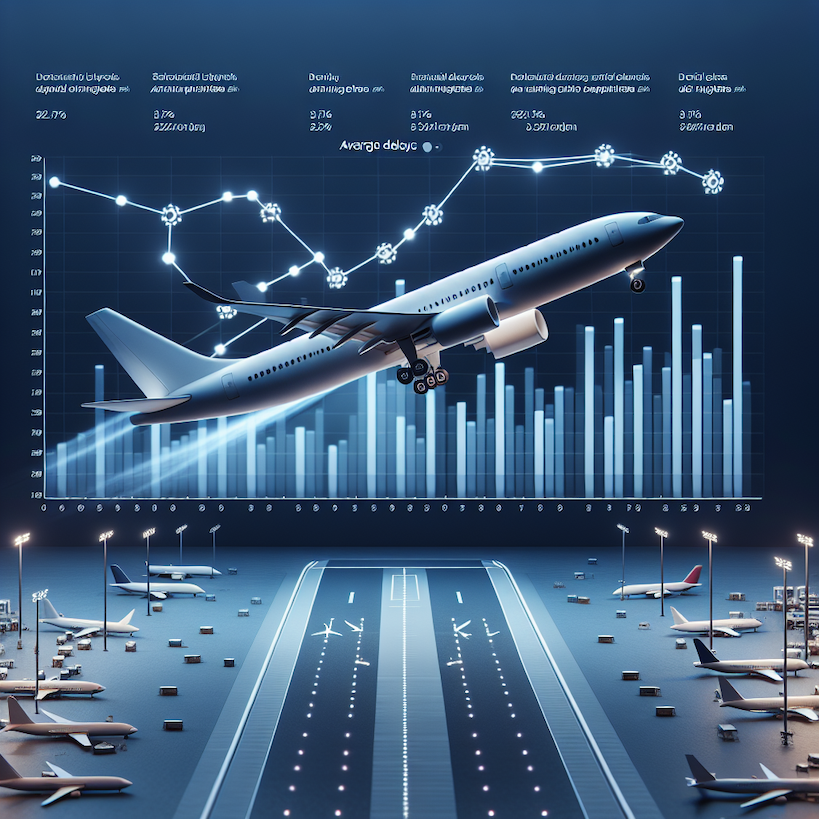

# Introducción al Notebook: Predicción de Retrasos de Vuelos

Este proyecto busca anticipar el riesgo de retraso, permitiendo tomar decisiones preventivas y mejorar la planificación operativa por medio de desarrollo y evalución de modelos de Machine Learning capaces de predecir si un vuelo despegará puntual o con retraso, usando información disponible antes del vuelo. El resultado es un modelo listo para ser consumido por una API REST, permitiendo su uso en tiempo real por aerolíneas, aeropuertos o sistemas externos.

Se abordan las fases clave de un proyecto de ciencia de datos:

1.  **Carga y Exploración de Datos:** Se carga un dataset que combina información de vuelos con datos meteorológicos.
2.  **Preprocesamiento de Datos:** Se limpian los datos, se manejan valores nulos y se transforman las variables para hacerlas aptas para los modelos.
3.  **Entrenamiento y Evaluación de Modelos:** Se construyen y entrenan dos tipos de modelos: Regresión Logística (un modelo base simple) y Random Forest (un modelo de conjunto más avanzado). Ambos se evalúan utilizando métricas como el Classification Report, ROC AUC y Matrices de Confusión.
4.  **Simulación de Predicciones:** Se crea una función que simula un "endpoint" de API para realizar predicciones con nuevos datos, mostrando cómo se usaría el modelo en un entorno real.
5.  **Análisis de Resultados y Conclusiones:** Se analizan los resultados de los modelos, se visualizan su rendimiento y se extraen conclusiones sobre cuál es el mejor modelo para el caso de uso, junto con posibles mejoras futuras.

## Definición del Problema de Data Science

Tipo de problema: Clasificación binaria

Variable objetivo:

*   `delayed=0` → Vuelo puntual
*   `delayed=1` → Vuelo retrasado

Pregunta que responde el modelo:

¿Este vuelo tiene una alta probabilidad de retrasarse?

---------

# **1. 📚 Librerías y configuración**
---

In [2]:
!pip install kagglehub pyarrow requests

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    classification_report,
    roc_curve,
    roc_auc_score,
    auc
)

import joblib
import kagglehub
import pyarrow as pa
import pyarrow.parquet as pq
import os
import requests


sns.set(style="whitegrid")

## Descargar el dataset de Rafael para el analisis e entrenamiento

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = kagglehub.dataset_download("arvindnagaonkar/flight-delay")
print("Dataset descargado en:")
print(path)

# Lista los archivos disponibles dentro del dataset descargado
os.listdir(path)

# Construimos la ruta al archivo parquet
# ParquetFile permite leer el dataset sin cargarlo entero en memoria
PARQUET_FILE = os.path.join(path, "Flight_Delay.parquet")

OUT_FILE = "df_sample_equal_year.parquet"

BATCH_SIZE = 200_000
YEAR_COL = "Year"

# -------- 1) Primer pase: contar filas por Year (streaming) --------
pf = pq.ParquetFile(PARQUET_FILE)
counts = {}

for batch in pf.iter_batches(batch_size=BATCH_SIZE, columns=[YEAR_COL]):
    years = batch.column(0).to_numpy()
    uniq, cnt = np.unique(years, return_counts=True)
    for y, c in zip(uniq, cnt):
        counts[int(y)] = counts.get(int(y), 0) + int(c)

min_per_year = min(counts.values())  # mismo tamaño por Year

# (opcional) si quieres una fracción del mínimo:
# SAMPLE_FRAC = 0.10
# min_per_year = int(min_per_year * SAMPLE_FRAC)

print("Counts:", counts)
print("Rows per Year to keep:", min_per_year)

# -------- 2) Segundo pase: construir salida con N filas por Year --------
pf = pq.ParquetFile(PARQUET_FILE)

kept = {y: 0 for y in counts.keys()}
writer = None

for batch in pf.iter_batches(batch_size=BATCH_SIZE):  # lee todas las columnas
    df_chunk = batch.to_pandas()

    # seleccionar filas manteniendo cupo por year
    parts = []
    for y, g in df_chunk.groupby(YEAR_COL, sort=False):
        y = int(y)
        remaining = min_per_year - kept.get(y, 0)
        if remaining <= 0:
            continue
        take = g.iloc[:remaining]  # determinístico (primeras filas)
        kept[y] = kept.get(y, 0) + len(take)
        parts.append(take)

    if not parts:
        # si no hay nada que guardar de este batch, seguir
        continue

    out_df = pd.concat(parts, ignore_index=True)
    out_table = pa.Table.from_pandas(out_df, preserve_index=False)

    if writer is None:
        writer = pq.ParquetWriter(OUT_FILE, out_table.schema)
    writer.write_table(out_table)

    # early stop: si ya completaste todos los años, corta
    if all(v >= min_per_year for v in kept.values()):
        break

if writer is not None:
    writer.close()

print("Done. Written:", OUT_FILE)
print("Kept:", kept)

Using Colab cache for faster access to the 'flight-delay' dataset.
Dataset descargado en:
/kaggle/input/flight-delay
Counts: {2018: 6438556, 2019: 6707642, 2020: 4148123, 2021: 5234456, 2022: 5706055, 2023: 1897840}
Rows per Year to keep: 1897840
Done. Written: df_sample_equal_year.parquet
Kept: {2018: 1897840, 2019: 1897840, 2020: 1897840, 2021: 1897840, 2022: 1897840, 2023: 1897840}


In [6]:
print('Data source import complete.')
print ('Wait. Reading data...')
df = pd.read_parquet(OUT_FILE)

print("Finished reading data.")

Data source import complete.
Wait. Reading data...
Finished reading data.


## Cargar dataset por bloques

In [7]:
df.columns = df.columns.str.lower()


## **Inspección visual**




### Visualizar las primeras 5 filas.

In [8]:
df.head()

,year,month,dayofmonth,flightdate,marketing_airline_network,origincityname,destcityname,crsdeptime,deptime,depdelay,...,crselapsedtime,actualelapsedtime,airtime,distance,distancegroup,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,2018,1,15,2018-01-15,UA,"Newark, NJ","Charleston, SC",1845,1928.0,43.0,...,143.0,141.0,102.0,628.0,3,41.0,0.0,0.0,0.0,0.0
1,2018,1,16,2018-01-16,UA,"Newark, NJ","Charleston, SC",1835,1956.0,81.0,...,143.0,131.0,108.0,628.0,3,67.0,0.0,0.0,0.0,2.0
2,2018,1,17,2018-01-17,UA,"Newark, NJ","Charleston, SC",1835,1836.0,1.0,...,143.0,138.0,113.0,628.0,3,0.0,0.0,0.0,0.0,0.0
3,2018,1,18,2018-01-18,UA,"Newark, NJ","Charleston, SC",1845,1844.0,-1.0,...,143.0,134.0,92.0,628.0,3,0.0,0.0,0.0,0.0,0.0
4,2018,1,20,2018-01-20,UA,"Newark, NJ","Charleston, SC",1835,1829.0,-6.0,...,143.0,117.0,89.0,628.0,3,0.0,0.0,0.0,0.0,0.0


### **Estructura**

*   Revisar cuántas filas y columnas hay.

In [9]:
print(f"Cantidad de columnas y filas: {df.shape}")

Cantidad de columnas y filas: (11387040, 29)


*   Qué tipo de datos contiene cada una (¿son números, fechas, texto?)

In [10]:
df.dtypes

,0
year,int64
month,int64
dayofmonth,int64
flightdate,object
marketing_airline_network,object
origincityname,object
destcityname,object
crsdeptime,int64
deptime,float64
depdelay,float64


In [11]:
df["year"].value_counts(normalize=True)

,proportion
year,
2018,0.166667
2019,0.166667
2020,0.166667
2021,0.166667
2022,0.166667
2023,0.166667


### **Estadística básica**

*   Calcular medias, medianas y desviaciones estándar para entender la distribución de los números.

In [12]:
df.describe()

,year,month,dayofmonth,crsdeptime,deptime,depdelay,depdelayminutes,taxiout,wheelsoff,wheelson,...,crselapsedtime,actualelapsedtime,airtime,distance,distancegroup,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
count,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,...,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07
mean,2.020500e+03,7.043439e+00,1.575966e+01,1.321977e+03,1.326603e+03,9.950408e+00,1.369059e+01,1.678697e+01,1.350283e+03,1.463278e+03,...,1.395519e+02,1.324512e+02,1.081906e+02,7.743345e+02,3.571761e+00,5.092951e+00,8.002110e-01,2.728657e+00,2.584412e-02,5.176241e+00
std,1.707825e+00,4.625220e+00,8.788867e+00,4.817687e+02,4.938183e+02,5.205214e+01,5.091288e+01,9.502332e+00,4.947307e+02,5.179606e+02,...,7.108328e+01,7.062528e+01,6.888038e+01,5.805945e+02,2.283863e+00,3.443722e+01,1.600639e+01,1.496646e+01,1.544805e+00,2.731208e+01
min,2.018000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-3.420000e+02,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,...,-2.920000e+02,1.100000e+01,-1.412000e+03,1.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.019000e+03,1.000000e+00,8.000000e+00,9.150000e+02,9.190000e+02,-6.000000e+00,0.000000e+00,1.100000e+01,9.340000e+02,1.053000e+03,...,8.900000e+01,8.100000e+01,5.800000e+01,3.510000e+02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.020500e+03,1.000000e+01,1.600000e+01,1.315000e+03,1.321000e+03,-3.000000e+00,0.000000e+00,1.400000e+01,1.335000e+03,1.500000e+03,...,1.210000e+02,1.150000e+02,9.000000e+01,6.180000e+02,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.022000e+03,1.100000e+01,2.300000e+01,1.725000e+03,1.733000e+03,3.000000e+00,3.000000e+00,1.900000e+01,1.747000e+03,1.903000e+03,...,1.700000e+02,1.620000e+02,1.370000e+02,1.011000e+03,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.023000e+03,1.200000e+01,3.100000e+01,2.359000e+03,2.400000e+03,4.413000e+03,4.413000e+03,1.439000e+03,2.400000e+03,2.400000e+03,...,1.645000e+03,7.640000e+02,7.270000e+02,5.095000e+03,1.100000e+01,4.218000e+03,2.098000e+03,1.660000e+03,1.460000e+03,2.962000e+03



---

> **Aquí se presentan las estadísticas clave**:
>
> - **count (conteo)**: Confirma la completitud de los datos (sin nulos en estas columnas).
>
> - **mean y median (50%)**: Comparar estos valores ayuda a identificar el sesgo de la distribución. Si la media es significativamente mayor que la mediana, sugiere un sesgo positivo (cola larga hacia la derecha), como es el caso de los retrasos (`depdelay`, `depdelayminutes`, `arrdelayminutes`), indicando que la mayoría de los vuelos salen/llegan a tiempo o antes, pero hay algunos retrasos muy largos que tiran la media hacia arriba.
> - **std (desviación estándar)**: Mide la dispersión de los datos. Un `std` alto en relación con la `mean` (como en `depdelay`) indica una gran variabilidad, lo que significa que los valores individuales se desvían mucho del promedio. Esto es crucial para entender la imprevisibilidad de los retrasos.
> - **min y max**: Revelan el rango completo de los datos y la presencia de valores extremos. Por ejemplo, `min` negativos para `depdelay` y `depdelayminutes` indican vuelos que salieron antes de lo programado. `max` muy altos en los retrasos confirman la existencia de outliers o eventos de retraso muy significativos. El `max` de `distance` muestra vuelos de muy larga distancia.
> - **cuartiles (25%, 50%, 75%)**: Proporcionan una visión de la distribución interna de los datos. Por ejemplo, para los retrasos, un 75% bajo (o incluso negativo) sugiere que la mayoría de los vuelos se ajustan a un horario puntual, y los retrasos significativos son menos frecuentes pero potentes. En `distance`, muestran cómo se distribuyen las distancias de vuelo típicas.



# **2. Limpieza de Datos (Data Cleaning)**
---

### **Valores faltantes**

*   ¿Hay celdas vacías? Debes decidir si borras esas filas o rellenas los huecos con la media o un valor lógico.

In [13]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11387040 entries, 0 to 11387039
Data columns (total 29 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   year                       int64  
 1   month                      int64  
 2   dayofmonth                 int64  
 3   flightdate                 object 
 4   marketing_airline_network  object 
 5   origincityname             object 
 6   destcityname               object 
 7   crsdeptime                 int64  
 8   deptime                    float64
 9   depdelay                   float64
 10  depdelayminutes            float64
 11  taxiout                    float64
 12  wheelsoff                  float64
 13  wheelson                   float64
 14  taxiin                     float64
 15  crsarrtime                 int64  
 16  arrtime                    float64
 17  arrdelay                   float64
 18  arrdelayminutes            float64
 19  crselapsedtime             float64
 20  

---
> Según la salida de `df.info()`, todas las columnas en ese conjunto de datos muestran un conteo de no nulos de 100,000, lo que coincide con el índice de rango total de 100,000 entradas. Esto significa que no hay valores faltantes en este DataFrame. Por lo tanto, no es necesario tomar ninguna medida para eliminar filas o llenar espacios vacíos.

### **Duplicados**

*   Eliminar registros repetidos que puedan sesgar los resultados.

In [14]:
num_duplicates = df.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

Número de filas duplicadas: 0


---
> La salida muestra: `"Number of duplicate rows: 0"`. Esto significa que no hay entradas duplicadas en el DataFrame, por lo que no es necesario tomar medidas adicionales para eliminarlas.



### **Formateo**

*  Asegurarse de que las fechas sean tratadas como fechas y no como simple texto.
*  Convertir fecha/hora a datetime.

---


> La columna `flightdate` se ha convertido exitosamente al tipo de dato `datetime64[ns]`, lo que significa que está correctamente formateada para cualquier operación o análisis basado en fechas.



# **3. Análisis Exploratorio de Datos (EDA)**
---

## **Detección de Outliers**

Identificar valores atípicos (por ejemplo, un sueldo de un billón de dólares en una lista de empleados comunes) que podrían arruinar el modelo.

## **Contar y mostrar outliers**

*   Contar el número de puntos de datos que están por debajo del límite inferior o por encima del límite superior para cada columna numérica. Mostrar estos conteos para indicar cuántos outliers hay en cada variable.

Para contar el número de outliers en cada columna numérica, itera a través de las columnas en `df_numeric`, aplica los límites inferior y superior definidos para identificar los outliers y almacenaré los conteos en un diccionario.



In [15]:
outlier_counts = {}

# Calculate Q1, Q3, IQR, lower_bound, and upper_bound within this cell
Q1 = df.select_dtypes(include='number').quantile(0.25)
Q3 = df.select_dtypes(include='number').quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for column in df.select_dtypes(include='number').columns:
    # Skip Year and Month columns as they are constant in this dataset sample
    if column in ['Year', 'Month']:
        continue

    # Count outliers for each column
    num_outliers = df.select_dtypes(include='number')[(df.select_dtypes(include='number')[column] < lower_bound[column]) | (df.select_dtypes(include='number')[column] > upper_bound[column])].shape[0]
    outlier_counts[column] = num_outliers

sorted_outliers = sorted(outlier_counts.items(), key=lambda item: item[1], reverse=True)

print("Número de outliers por columna numérica")
print("****************************************\n")
for col, count in sorted_outliers:
    print(f"{col}: {count}")


Número de outliers por columna numérica
****************************************

arrdelayminutes: 2394230
depdelayminutes: 2347465
depdelay: 1874739
arrdelay: 1837224
carrierdelay: 1301757
nasdelay: 1204137
lateaircraftdelay: 1128890
taxiout: 663249
distance: 608157
taxiin: 605112
airtime: 582809
crselapsedtime: 577590
actualelapsedtime: 572656
distancegroup: 454149
weatherdelay: 127632
securitydelay: 11176
year: 0
month: 0
dayofmonth: 0
crsdeptime: 0
deptime: 0
wheelsoff: 0
wheelson: 0
crsarrtime: 0
arrtime: 0


*   Ahora que se han calculado y mostrado los conteos de outliers, el siguiente paso es visualizar estos outliers para columnas numéricas clave utilizando diagramas de caja. Esto proporcionará una representación gráfica de la distribución y la magnitud de los outliers.

TypeError: list indices must be integers or slices, not str

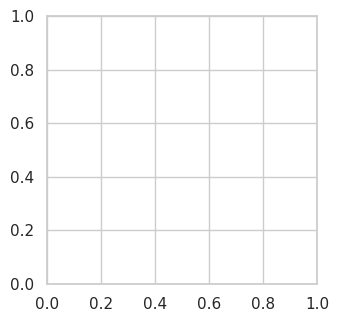

In [17]:
# Identify columns with a significant number of outliers for visualization
# Selecting columns that have more than 5000 outliers for better visualization of impact
key_outlier_columns = [col for col, count in sorted_outliers if count > 5000]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Calculate the number of rows and columns for the subplot grid
num_plots = len(key_outlier_columns)
num_cols = 4  # You can adjust this for desired layout
num_rows = (num_plots + num_cols - 1) // num_cols  # Ceiling division

# Create box plots for the key outlier columns
plt.figure(figsize=(num_cols * 4, num_rows * 4)) # Adjust figure size dynamically
for i, column in enumerate(key_outlier_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(y=sorted_outliers[column], color='skyblue')
    plt.title(f'Box Plot de {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

---
> **Observaciones clave de los gráficos**
>
> A partir de los gráficos de caja y los histogramas, podemos observar lo siguiente:
>
> *   **Línea central en la caja**: Representa la mediana (50º percentil) de los datos.
> *   **La caja**: Delimita el Rango Intercuartílico (IQR), que es donde se encuentra el 50% central de los datos (entre el 25º y el 75º percentil).
> *   **Los 'bigotes'**: Se extienden desde la caja hasta el último dato que no se considera atípico, generalmente 1.5 veces el IQR desde los cuartiles.
> *   **Puntos individuales fuera de los 'bigotes'**: Estos son los outliers (valores atípicos), los cuales ya habíamos cuantificado. Su ubicación y densidad nos dan una idea de la magnitud de estos valores extremos.
>
> Para las columnas relacionadas con retrasos (`depdelay`, `depdelayminutes`, `arrdelayminutes`, `nasdelay`, `lateaircraftdelay`, `carrierdelay`):
>
> *   Se observa un marcado sesgo positivo, con la mayoría de los datos concentrados en valores bajos (cerca de cero o negativos) y una larga cola de outliers hacia arriba, indicando la presencia de retrasos muy significativos que se extienden a valores muy altos.
>
> Para la columna `distance`:
>
> *   Muestra una distribución con una concentración en distancias más cortas y algunos outliers hacia el extremo superior, lo que representa vuelos de muy larga distancia.




---

> **Aquí se presentan las estadísticas clave**:
>
> - **count (conteo)**: Confirma la completitud de los datos (sin nulos en estas columnas).
>
> - **mean y median (50%)**: Comparar estos valores ayuda a identificar el sesgo de la distribución. Si la media es significativamente mayor que la mediana, sugiere un sesgo positivo (cola larga hacia la derecha), como es el caso de los retrasos (`depdelay`, `depdelayminutes`, `arrdelayminutes`), indicando que la mayoría de los vuelos salen/llegan a tiempo o antes, pero hay algunos retrasos muy largos que tiran la media hacia arriba.
> - **std (desviación estándar)**: Mide la dispersión de los datos. Un `std` alto en relación con la `mean` (como en `depdelay`) indica una gran variabilidad, lo que significa que los valores individuales se desvían mucho del promedio. Esto es crucial para entender la imprevisibilidad de los retrasos.
> - **min y max**: Revelan el rango completo de los datos y la presencia de valores extremos. Por ejemplo, `min` negativos para `depdelay` y `depdelayminutes` indican vuelos que salieron antes de lo programado. `max` muy altos en los retrasos confirman la existencia de outliers o eventos de retraso muy significativos. El `max` de `distance` muestra vuelos de muy larga distancia.
> - **cuartiles (25%, 50%, 75%)**: Proporcionan una visión de la distribución interna de los datos. Por ejemplo, para los retrasos, un 75% bajo (o incluso negativo) sugiere que la mayoría de los vuelos se ajustan a un horario puntual, y los retrasos significativos son menos frecuentes pero potentes. En `distance`, muestran cómo se distribuyen las distancias de vuelo típicas.



## **Correlaciones**

¿Si la variable A sube, la variable B también? Esto nos dirá qué datos son realmente importantes para la predicción.

A continuación, para cada columna numérica, calculará algo llamado Rango Intercuartílico (IQR). El IQR ayuda a definir límites que nos indican qué tan lejos están los datos de lo que se considera normal. Para calcularlo, se debe encontrar dos valores especiales:

*   Q1: el primer cuartil, que es el valor que separa el 25% inferior de los datos.
*   Q3: el tercer cuartil, que separa el 25% superior de los datos.
*   Luego, se calculará el IQR restando Q1 de Q3. Para definir los límites que nos ayudarán a identificar los "outliers" (valores atípicos), se usará la siguiente fórmula: `lower_bound = Q1 - 1.5 * IQR` and `upper_bound = Q3 + 1.5 * IQR`

In [16]:

print("**************************")
print("Lower Bounds for Outliers:")
print("**************************")
print(lower_bound)
print("\n**************************")
print("Upper Bounds for Outliers:")
print("**************************")
print(upper_bound)

**************************
Lower Bounds for Outliers:
**************************
year                 2014.5
month                 -14.0
dayofmonth            -14.5
crsdeptime           -300.0
deptime              -302.0
depdelay              -19.5
depdelayminutes        -4.5
taxiout                -1.0
wheelsoff            -285.5
wheelson             -222.0
taxiin                 -3.5
crsarrtime            -94.5
arrtime              -219.5
arrdelay              -41.0
arrdelayminutes         0.0
crselapsedtime        -32.5
actualelapsedtime     -40.5
airtime               -60.5
distance             -639.0
distancegroup          -2.5
carrierdelay            0.0
weatherdelay            0.0
nasdelay                0.0
securitydelay           0.0
lateaircraftdelay       0.0
dtype: float64

**************************
Upper Bounds for Outliers:
**************************
year                 2026.5
month                  26.0
dayofmonth             45.5
crsdeptime           2940.0
deptime   

## **Distribuciones**

*   Revisar si los datos siguen una curva normal o si están muy sesgados hacia un lado.
*   Buscar patrones usando gráficos (Matplotlib, Seaborn o Plotly).

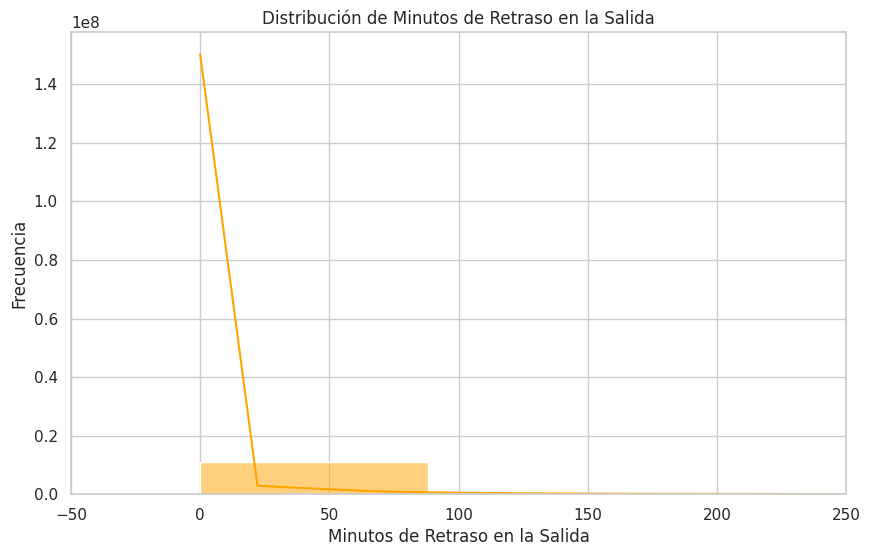

In [10]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df.select_dtypes(include='number')['depdelayminutes'], bins=50, kde=True, color='orange')
plt.title('Distribución de Minutos de Retraso en la Salida')
plt.xlabel('Minutos de Retraso en la Salida')
plt.ylabel('Frecuencia')
plt.xlim(-50, 250) # Adjusted x-limit for better visibility of main distribution and tail
plt.show()

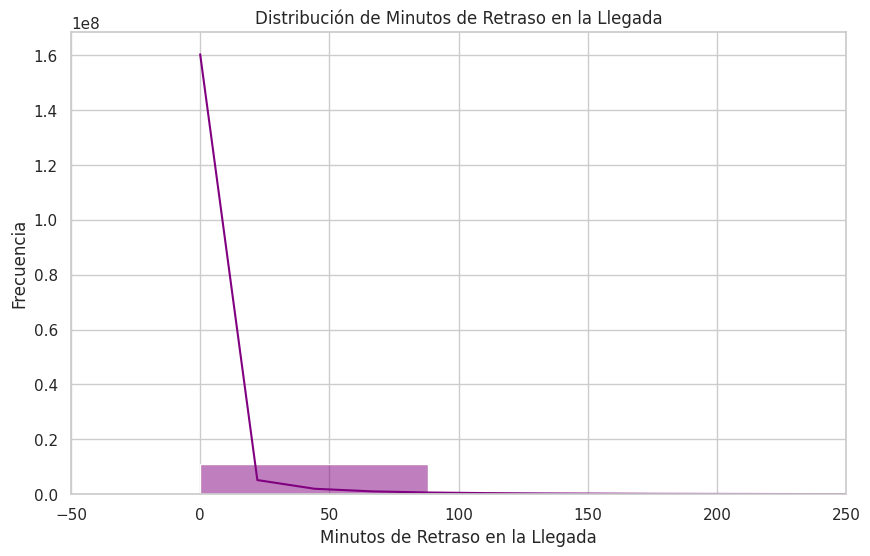

In [12]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df.select_dtypes(include='number')['arrdelayminutes'], bins=50, kde=True, color='purple')
plt.title('Distribución de Minutos de Retraso en la Llegada')
plt.xlabel('Minutos de Retraso en la Llegada')
plt.ylabel('Frecuencia')
plt.xlim(-50, 250) # Adjusted x-limit for better visibility of main distribution and tail
plt.show()

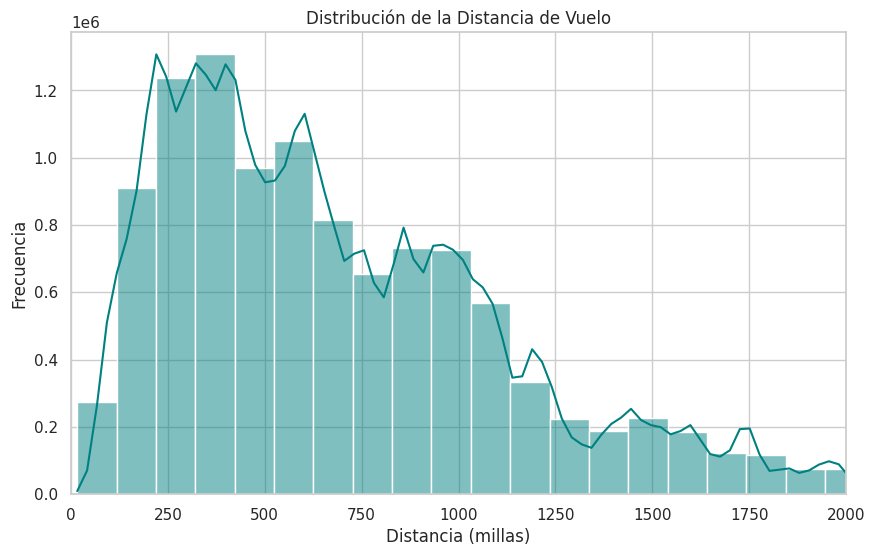

In [13]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df.select_dtypes(include='number')['distance'], bins=50, kde=True, color='teal')
plt.title('Distribución de la Distancia de Vuelo')
plt.xlabel('Distancia (millas)')
plt.ylabel('Frecuencia')
plt.xlim(0, 2000) # Adjusted x-limit to show most common distances without extreme long-haul flights
plt.show()

### Resumen del Análisis de Distribución

---
> Basado en los histogramas generados para `depDelayminutes`, `arrdelayminutes`, y `distance`, las distribuciones:
>
> *   **`depdelayminutes`** y **`arrdelayminutes`**: Ambas muestran distribuciones altamente sesgadas. Hay un pico muy fuerte en cero o cerca de cero, lo que indica que una gran mayoría de los vuelos salen y llegan a tiempo o incluso antes. Sin embargo, hay una larga cola que se extiende hacia la derecha, lo que muestra que, aunque son menos frecuentes, ocurren retrasos significativos. Estas distribuciones claramente no son normales y están fuertemente sesgadas positivamente.
>
> *   **`distance`**: La distribución de la distancia también está sesgada hacia la derecha, pero de manera menos dramática que las columnas de retraso. Muestra una mayor frecuencia para vuelos cortos, con la frecuencia disminuyendo gradualmente a medida que la distancia aumenta. Hay menos vuelos de larga distancia, lo que crea una cola hacia valores más altos. Esto es típico en conjuntos de datos de vuelos, donde muchas rutas de distancia corta a media son comunes, mientras que los vuelos internacionales muy largos son más raros.

## **Tipos de retrasos más comunes**

Vamos a crear un gráfico de barras para visualizar la frecuencia de cada causa de retraso. Esto nos mostrará qué tipos de retrasos son los más comunes en el conjunto de datos.

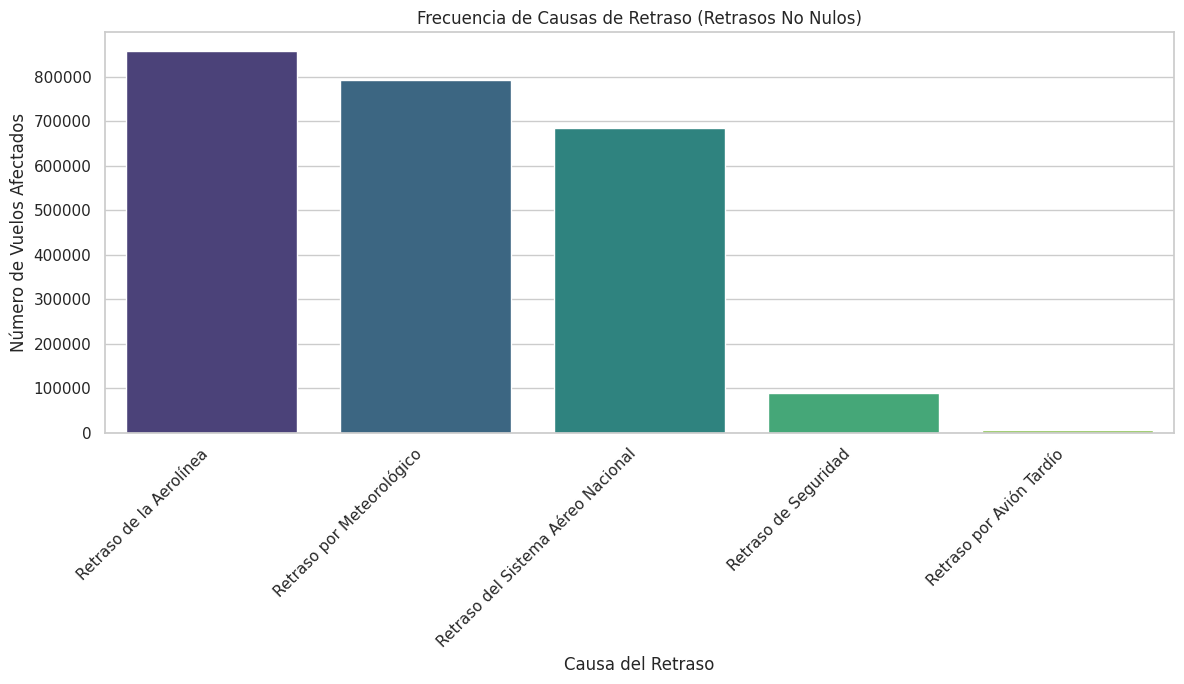

In [17]:
delay_cause_columns = [
    'carrierdelay',
    'weatherdelay',
    'nasdelay',
    'securitydelay',
    'lateaircraftdelay'
]

delay_cause_columns_map = {
    0: 'Retraso de la Aerolínea',
    1: 'Retraso por Meteorológico',
    2: 'Retraso del Sistema Aéreo Nacional',
    3: 'Retraso de Seguridad',
    4: 'Retraso por Avión Tardío',
}


# Count the number of non-zero delays for each cause
frequency_of_causes = {}
for col in delay_cause_columns:
    # A flight is considered to have a delay cause if the delay is > 15
    frequency_of_causes[col] = df.select_dtypes(include='number')[df.select_dtypes(include='number')[col] > 15].shape[0]

# Convert to a pandas Series for easy plotting
frequency_series = pd.Series(frequency_of_causes).sort_values(ascending=False)

sns.set_style("whitegrid")

plt.figure(figsize=(12, 7))
sns.barplot(
    x=frequency_series.index,
    y=frequency_series.values,
    hue=frequency_series.index,
    palette='viridis',
    legend=False
)
plt.title('Frecuencia de Causas de Retraso (Retrasos No Nulos)')
plt.xlabel('Causa del Retraso')
plt.ylabel('Número de Vuelos Afectados')
plt.xticks(
    ticks=range(5),
    labels=[delay_cause_columns_map[i] for i in range(5)],
    rotation=45, ha='right'
)
plt.tight_layout()
plt.show()

---
> ### **Observaciones clave del gráfico**
>
> El gráfico de barras anterior muestra el número de vuelos afectados por cada causa específica de retraso, considerando solo los minutos de retraso no nulos. Esta visualización ayuda a identificar los tipos de retrasos más frecuentes en nuestro conjunto de datos. Podemos observar que `carrierdelay`, `lateaircraftdelay` y `nasdelay` son las causas más frecuentes, afectando a miles de vuelos, mientras que `weatherdelay` y especialmente `securitydelay` son menos frecuentes.

## **Probabilidad de retraso de vuelo por hora de salida programada**

In [18]:
# Crear variable temporal 'hour' a partir de la hora programada
df["hour"] = df.select_dtypes(include='number')["crsdeptime"] // 100  # solo la hora

# Variable objetivo 'delayed': 1 si el retraso en salida >= 15 min
df["delayed"] = (df.select_dtypes(include='number')["depdelay"] >= 15).astype(int)

# Probabilidad de delay en la muestra
delay_rate = df["delayed"].mean()
print(f"Delay rate: {delay_rate:.4f}")

# Probabilidad de delay en la muestra
delay_rate = df["delayed"].mean()
print(f"Delay rate: {delay_rate:.4f}")

# Ver valores únicos de la variable 'delayed'
unique_values = df["delayed"].unique()
print("Valores únicos en 'delayed':", unique_values)

Delay rate: 0.1698
Delay rate: 0.1698
Valores únicos en 'delayed': [1 0]


hour
0     0.180245
1     0.176570
2     0.239925
3     0.256506
4     0.229794
5     0.071609
6     0.074890
7     0.092360
8     0.110538
9     0.128383
10    0.145465
11    0.154597
12    0.168808
13    0.183205
14    0.193270
15    0.201940
16    0.213464
17    0.215501
18    0.230330
19    0.242814
20    0.233717
21    0.242783
22    0.213937
23    0.197289
Name: delayed, dtype: float64


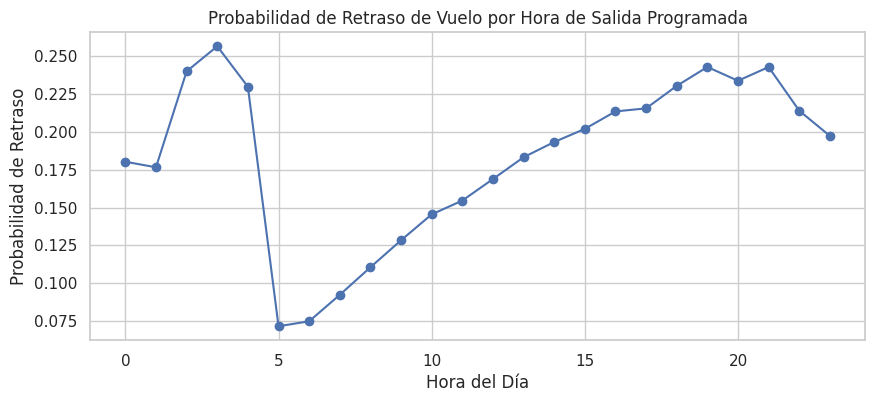

In [19]:
import matplotlib.pyplot as plt

# Agrupar por hora y calcular la probabilidad de retraso
hour_delay = (
    df.groupby("hour")["delayed"]
    .mean()
    .sort_index()
)

# Mostrar la tabla de probabilidades por hora
print(hour_delay)


plt.figure(figsize=(10,4))
hour_delay.plot(kind="line", marker="o")
plt.title("Probabilidad de Retraso de Vuelo por Hora de Salida Programada")
plt.xlabel("Hora del Día")
plt.ylabel("Probabilidad de Retraso")
plt.grid(True)
plt.show()

---
> ### **Observaciones clave del gráfico**
>
> *   **Baja Probabilidad de Retraso en la Temprana Mañana**: La probabilidad de retraso es generalmente baja durante las primeras horas de la mañana (por ejemplo, de 1 AM a 6 AM). Los vuelos programados para despegar en este intervalo tienden a tener menos posibilidades de ser retrasados.
>
> *   **Aumento de la Probabilidad a lo Largo del Día**: A medida que avanza el día, la probabilidad de que un vuelo sea retrasado aumenta de manera constante. Esta tendencia se vuelve más notable desde finales de la mañana hasta la tarde y el principio de la noche.
>
> *   **Pico de Probabilidad de Retraso en la Tarde/Noche**: Las mayores probabilidades de retraso se observan en la tarde y a inicios de la noche (aproximadamente entre las 4 PM y las 9 PM). Esto se debe a una combinación de factores: retrasos acumulativos de horas anteriores, mayor tráfico aéreo y posibles cambios climáticos.
>
> *   **Ligera Disminución a Última Hora de la Noche**: Hacia las últimas horas de la noche (por ejemplo, a partir de las 10 PM), la probabilidad de retraso tiende a disminuir nuevamente, probablemente debido a la reducción del tráfico aéreo.

## **Probabilidad de retraso según la distancia de vuelo**

distance_bin
(15.999, 305.0]     0.156193
(305.0, 507.0]      0.156351
(507.0, 762.0]      0.167379
(762.0, 1107.0]     0.184747
(1107.0, 5095.0]    0.184449
Name: delayed, dtype: float64


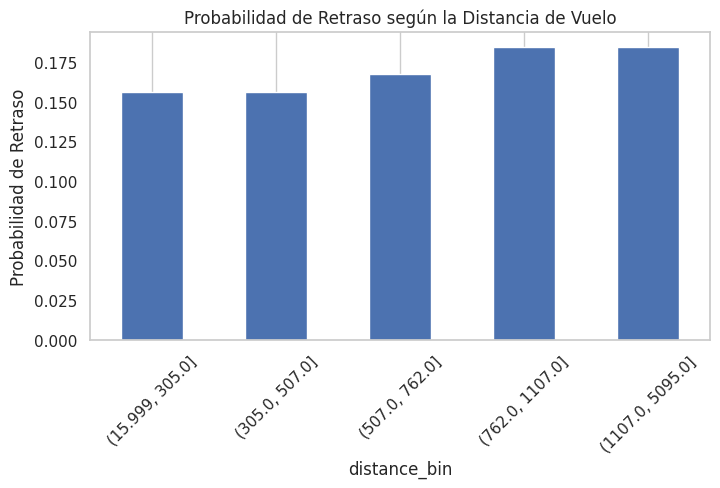

In [20]:
# Crear bins de distancia (5 quintiles)
df["distance_bin"] = pd.qcut(df.select_dtypes(include='number')["distance"], q=5)

# Calcular probabilidad de retraso por rango de distancia
distance_delay = (
    df.groupby("distance_bin", observed=True)["delayed"]
    .mean()
)


print(distance_delay)

plt.figure(figsize=(8,4))
distance_delay.plot(kind="bar")
plt.title("Probabilidad de Retraso según la Distancia de Vuelo")
plt.ylabel("Probabilidad de Retraso")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

---
> ### **Observaciones clave del gráfico**
>
> *   **Probabilidad Variada según las Distancias**: La probabilidad de retraso no es constante en todas las distancias de vuelo. Varía dependiendo de la longitud del vuelo.
>
> *   **Vuelos Cortos Tienen Menor Probabilidad de Retraso**: Los vuelos más cortos (rango de distancia (`15.999, 296.0`]) muestran la menor probabilidad de retraso (alrededor del 15%). Esto puede deberse a que las rutas más cortas son menos propensas a acumular retrasos o a enfrentar condiciones climáticas variadas.
>
> *   **Vuelos Intermedios y Largos**: Los vuelos en rangos de distancia intermedios y largos ((`296.0, 484.0`], (`484.0, 760.0`], (`760.0, 1099.0`], (`1099.0, 4983.0`]) tienden a tener probabilidades de retraso ligeramente más altas y más consistentes, que oscilan aproximadamente entre el 18% y el 19%.
>
> *   **Sin Relación Lineal Directa**: No hay una relación lineal clara y fuerte donde la probabilidad de retraso aumente o disminuya continuamente con la distancia. En cambio, parece fluctuar dentro de un cierto rango para vuelos de media a larga distancia después de una probabilidad inicial más baja para vuelos muy cortos.

## **Probabilidad de retraso por día de la semana**

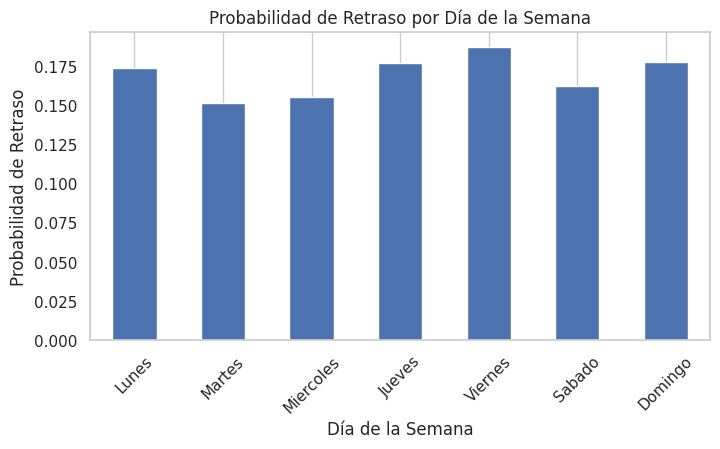

In [21]:
# Convertir a datetime (ya hecho en df, pero aseguramos si df_numeric no lo tiene)
# Asumimos que df_numeric y df tienen el mismo índice y número de filas
# y que df['flightdate'] ya es datetime de un paso anterior
df["day_of_week"] = pd.to_datetime(df["flightdate"]).dt.dayofweek

# Map day numbers to day names
days_map = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miercoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sabado',
    6: 'Domingo'
}

# Calcular probabilidad de retraso por día de la semana
dow_delay = (
    df.groupby("day_of_week")["delayed"]
    .mean()
    .sort_index()
)

# Graficar
plt.figure(figsize=(8,4))
dow_delay.plot(kind="bar")
plt.xticks(
    ticks=range(7),
    labels=[days_map[i] for i in range(7)],
    rotation=45
)
plt.title("Probabilidad de Retraso por Día de la Semana")
plt.xlabel("Día de la Semana")
plt.ylabel("Probabilidad de Retraso")
plt.grid(axis="y")
plt.show()

---
> **Observaciones clave del gráfico**
>*   **Mayor Probabilidad de Retraso los Lunes**: El gráfico probablemente muestra que los vuelos los lunes tienen una probabilidad relativamente más alta de ser retrasados. Esto podría deberse a una mayor demanda de viajes al comienzo de la semana laboral, a viajes de negocios o a retrasos acumulados del fin de semana.
>
>*   **Probabilidades Más Bajas en Mitad de Semana**: Típicamente, los días de mitad de semana como martes, miércoles y jueves pueden mostrar probabilidades de retraso ligeramente más bajas en comparación con el inicio o el final de la semana. Las operaciones pueden ser más fluidas con menos pasajeros y menos congestión.
>
>*   **Aumento de Probabilidades Hacia el Fin de Semana**: Los viernes pueden mostrar un aumento en la probabilidad de retraso nuevamente, a menudo atribuido al aumento de viajes por ocio y un mayor volumen de vuelos a medida que las personas viajan para el fin de semana.
>
>*   **Variabilidad en los Fines de Semana**: Sábados y domingos pueden tener patrones variados. A veces, los sábados muestran probabilidades más bajas debido a un tráfico de negocios más ligero, mientras que los domingos pueden aumentar debido a los viajes de regreso.



## **Top 10 Aerolíneas por probabilidad de retraso**

marketing_airline_network
F9    0.257998
B6    0.252006
G4    0.244964
NK    0.203306
WN    0.194534
HA    0.177579
UA    0.168679
AA    0.163093
AS    0.155722
VX    0.143658
Name: delayed, dtype: float64


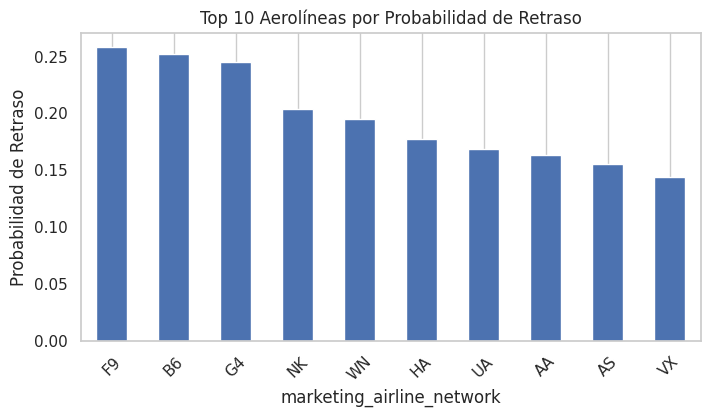

In [22]:
# Probabilidad de retraso por aerolínea (top 10)
alert_data = (
    df.groupby("marketing_airline_network")["delayed"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Mostrar resultados
print(alert_data)

# Graficar
plt.figure(figsize=(8,4))
alert_data.plot(kind="bar")
plt.title("Top 10 Aerolíneas por Probabilidad de Retraso")
plt.ylabel("Probabilidad de Retraso")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# **4. Ingeniería de Variables (Feature Engineering)**
---

## **Comprobación de variable objetivo binaria**

In [23]:
df["delayed"].value_counts(normalize=True)

hour_delay = (
    df.groupby("hour")["delayed"]
    .mean()
)

hour_std = hour_delay.std()

print(f"La probabilidad de retraso de los vuelos en promedio\na lo largo de las diferentes horas del día: {hour_std:.2%}")

La probabilidad de retraso de los vuelos en promedio
a lo largo de las diferentes horas del día: 5.49%


---
>
> Este criterio mide cuánto cambia la probabilidad de retraso a lo largo del día;
> si la variación es alta, significa que la hora del vuelo influye de forma real
> en los retrasos, y el ratio entre datasets nos permite comparar cuál captura
> mejor ese patrón temporal sin necesidad de entrenar ni optimizar modelos.
>
> Al medir la variación de la probabilidad de retraso según la hora, verificamos
> que la hora del vuelo tiene impacto real, y usando el ratio podemos decidir
> qué dataset conserva mejor esa señal predictiva sin incurrir en mayor coste
> computacional.



*   Selección de las columnas para el entrenamiento
*   Normalización de nombres a minusculas
*   Elaboración de nuevas variables



In [24]:
# Subsample MVP
N = 5_000
frac = N / len(df)

df_base = (
    df.groupby("year", group_keys=False)
      .sample(frac=frac, random_state=42)
)

df_base.head()

,year,month,dayofmonth,flightdate,marketing_airline_network,origincityname,destcityname,crsdeptime,deptime,depdelay,...,distancegroup,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,hour,delayed,distance_bin,day_of_week
174634,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,1,0.0,0.0,0.0,0.0,0.0,22,0,"(15.999, 305.0]",2
1824459,2018,12,1,2018-12-01,WN,"New Orleans, LA","Atlanta, GA",830,827.0,-3.0,...,2,0.0,0.0,36.0,0.0,0.0,8,0,"(305.0, 507.0]",5
686618,2018,10,5,2018-10-05,DL,"Huntsville, AL","Atlanta, GA",937,929.0,-8.0,...,1,0.0,0.0,0.0,0.0,0.0,9,0,"(15.999, 305.0]",4
1815587,2018,12,8,2018-12-08,UA,"Newark, NJ","Fort Lauderdale, FL",1601,1558.0,-3.0,...,5,0.0,0.0,0.0,0.0,0.0,16,0,"(762.0, 1107.0]",5
708433,2018,10,7,2018-10-07,F9,"Denver, CO","Fort Myers, FL",1548,1538.0,-10.0,...,7,0.0,0.0,0.0,0.0,0.0,15,0,"(1107.0, 5095.0]",6


## Elaboración de dataset predictivo a partir del existente

### Consultar a la API externa sobre el clima para agregar al dataset de entrenamiento

In [26]:
# "Dallas, TX" -> "Dallas"
# Necesario para el geocoding

tmp = (
    df_base["origincityname"]
    .astype(str)
    .str.split(",", n=1, expand=True)
)

df_base["city_clean"] = tmp[0].str.strip()
df_base["state_clean"] = tmp[1].str.strip()  # lo que va después de la coma

df_base[["origincityname", "city_clean", "state_clean"]].head()

,origincityname,city_clean,state_clean
174634,"Chicago, IL",Chicago,IL
1824459,"New Orleans, LA",New Orleans,LA
686618,"Huntsville, AL",Huntsville,AL
1815587,"Newark, NJ",Newark,NJ
708433,"Denver, CO",Denver,CO


In [27]:
print(f'cantidad de ciudades por estado en dataset: {df_base[['city_clean','state_clean']].drop_duplicates().shape}')

cantidad de ciudades por estado en dataset: (274, 2)


In [28]:
print(f'cantidad de ciudades por nombre en dataset: {df_base[['city_clean']].drop_duplicates().shape}')

cantidad de ciudades por nombre en dataset: (269, 1)


In [29]:
import pandas as pd

URL_AIRPORTS = "https://davidmegginson.github.io/ourairports-data/airports.csv"

# 1) Descargar desde la URL (queda en memoria como DataFrame)
airports = pd.read_csv(URL_AIRPORTS)  # pandas permite leer CSV directo desde URL [web:497]

airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,NaN,NaN,K00A,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,NaN,NaN,00AA,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,NaN,NaN,00AK,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,NaN,NaN,00AL,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,NaN,NaN,00AN,00AN,NaN,NaN,NaN


In [30]:

# 3) (Opcional) Filtrar para aviación civil "normal" (excluye heliports / seaplane)
allowed_types = {"small_airport", "medium_airport", "large_airport"}
airports_civil = airports[airports["type"].isin(allowed_types)].copy()
airports_civil.head()

#iso_regionmunicipality

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,NaN,NaN,00AA,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,NaN,NaN,00AK,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,NaN,NaN,00AL,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,NaN,NaN,00AN,00AN,NaN,NaN,NaN
5,322127,00AS,small_airport,Fulton Airport,34.942803,-97.818019,1100.0,NaN,US,US-OK,Alex,no,NaN,NaN,00AS,00AS,NaN,NaN,NaN


In [31]:
airport = airports_civil.loc[
    airports_civil["name"].astype(str).str.contains(
        "Odessa" # "Sheremet" "Domodedovo International Airport"
        , case=False, na=False
    )
]

airport

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
18073,511360,CCP7,small_airport,Codessa South Airport,55.719801,-118.039116,2000.0,NaN,CA,CA-AB,Eaglesham,no,NaN,NaN,CCP7,CCP7,NaN,https://en.wikipedia.org/wiki/Eaglesham/Codesa...,NaN
20286,46493,CSL7,small_airport,Odessa / Strawberry Lakes Airstrip,50.364518,-103.740807,2160.0,NaN,CA,CA-SK,Qu'Appelle,no,NaN,NaN,CSL7,CSL7,http://www.soar.regina.sk.ca/,https://en.wikipedia.org/wiki/Odessa/Strawberr...,SL7
37495,18774,K43D,small_airport,Odessa Municipal Airport,47.347599,-118.677002,1737.0,NaN,US,US-WA,Odessa,no,NaN,NaN,K43D,43D,NaN,NaN,NaN
40219,20716,KODO,small_airport,Odessa Schlemeyer Field,31.920601,-102.387001,3004.0,NaN,US,US-TX,Odessa,no,NaN,ODT,KODO,ODO,http://www.co.ector.tx.us/default.aspx?Ector_C...,https://en.wikipedia.org/wiki/Odessa-Schlemeye...,"E02, Ector County"
59112,36205,SIQK,small_airport,Nova Odessa Airport,-22.781533,-47.334557,1909.0,SA,BR,BR-SP,Nova Odessa,no,NaN,NaN,SIQK,SP0194,NaN,NaN,Rodrigues
65644,6487,UKOO,medium_airport,Odessa International Airport,46.426800,30.676500,172.0,EU,UA,UA-51,Odessa,yes,UKOO,ODS,UKOO,NaN,http://www.airport.od.ua/,https://en.wikipedia.org/wiki/Odessa_Internati...,"Odesa Central, Міжнародний аеропорт Одеса"


In [32]:
airport['latitude_deg'].dtype

dtype('float64')

In [33]:
# airports: DataFrame ya cargado desde airports.csv (OurAirports)
# airports = pd.read_csv(URL_AIRPORTS)

# 1) Filtrar solo filas donde iso_region empieza con "US-"
df_us = airports.loc[
    airports["iso_region"].astype(str).str.startswith("US-"),
].copy()  # str.startswith para filtrar prefijos [web:526]

# 2) Crear state_clean = parte después del guion (US-AL -> AL)
df_us["state_clean"] = (
    df_us["iso_region"]
      .astype(str)
      .str.split("-", n=1, expand=True)[1]
      .str.strip()
)  # split con expand para crear columnas [web:412][web:405]

# 3) city_clean = municipality (solo renombre/copia)
df_us["city_clean"] = df_us["municipality"].astype(str)
df_us["latitude"] = df_us["latitude_deg"]
df_us["longitude"] = df_us["longitude_deg"]

# 4) Seleccionar columnas finales
df_export = df_us[[
    "type", "name", "latitude", "longitude",
    "state_clean", "city_clean"
]].copy()

df_export.head()


,type,name,latitude,longitude,state_clean,city_clean
0,heliport,Total RF Heliport,40.070985,-74.933689,PA,Bensalem
1,small_airport,Aero B Ranch Airport,38.704022,-101.473911,KS,Leoti
2,small_airport,Lowell Field,59.947733,-151.692524,AK,Anchor Point
3,small_airport,Epps Airpark,34.864799,-86.770302,AL,Harvest
4,small_airport,Katmai Lodge Airport,59.093287,-156.456699,AK,King Salmon


In [34]:
# 5) Exportar a CSV
df_export.to_csv("airports_us_clean.csv", index=False)



In [35]:
#merge coordenadas y dataset

df_base = df_base.merge(df_export, on=["city_clean", "state_clean"], how="left")
df_base.head()

,year,month,dayofmonth,flightdate,marketing_airline_network,origincityname,destcityname,crsdeptime,deptime,depdelay,...,hour,delayed,distance_bin,day_of_week,city_clean,state_clean,type,name,latitude,longitude
0,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,Children's Memorial Hospital Heliport,41.925598,-87.646400
1,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,Vertiport Chicago Heliport,41.862142,-87.670249
2,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,University of Chicago Hospitals Heliport,41.788399,-87.604202
3,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,Rose Nr 3 Heliport,41.812500,-87.663101
4,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,Presence Sts Mary and Elizabeth Medical Center...,41.902802,-87.682800


In [36]:
df_base.shape

(147759, 39)

In [37]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147759 entries, 0 to 147758
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   year                       147759 non-null  int64   
 1   month                      147759 non-null  int64   
 2   dayofmonth                 147759 non-null  int64   
 3   flightdate                 147759 non-null  object  
 4   marketing_airline_network  147759 non-null  object  
 5   origincityname             147759 non-null  object  
 6   destcityname               147759 non-null  object  
 7   crsdeptime                 147759 non-null  int64   
 8   deptime                    147759 non-null  float64 
 9   depdelay                   147759 non-null  float64 
 10  depdelayminutes            147759 non-null  float64 
 11  taxiout                    147759 non-null  float64 
 12  wheelsoff                  147759 non-null  float64 
 13  wheelson      

Para usar https://api.openweathermap.org/data/2.5/weather necesitas una API key asociada a una cuenta de OpenWeather.

Pasos para obtener la llave:

*   Crear una cuenta en OpenWeather (sign up).
*   Verificar el correo (OpenWeather indica que hay verificación por email y que luego se entrega un correo de bienvenida con la API key).
*   Entrar al dashboard/cuenta y ubicar la sección `API keys` (ahí puedes ver tu key y crear adicionales).


Primer codigo, por año 2018

In [39]:
import os
import time
import json
import math
import errno
import fcntl  # En Windows reemplaza por msvcrt.locking si lo necesitas
import requests
import pandas as pd

BASE_URL = "https://archive-api.open-meteo.com/v1/archive"
HARD_CAP = 10_000  # límite duro
DEFAULT_TIMEOUT = 15
MAX_RETRIES = 3
BACKOFF_BASE = 0.75  # segundos
WRITE_BATCH_SIZE = 500  # cada cuántas respuestas persistimos

def _safe_sleep(last_call_ts, min_interval_s):
    now = time.time()
    wait = (last_call_ts + min_interval_s) - now
    if wait > 0:
        time.sleep(wait)
    return time.time()

def _retry_get(session, url, params, timeout=DEFAULT_TIMEOUT, max_retries=MAX_RETRIES):
    for attempt in range(1, max_retries + 1):
        try:
            r = session.get(url, params=params, timeout=timeout)
            r.raise_for_status()
            return r
        except requests.RequestException as e:
            if attempt == max_retries:
                raise
            back = BACKOFF_BASE * (2 ** (attempt - 1))
            time.sleep(back)
    # No debería llegar aquí
    raise RuntimeError("Exhausted retries unexpectedly")

def fetch_daily_weather_for_point_date(lat, lon, date_str, timezone="UTC", session=None, timeout=DEFAULT_TIMEOUT):
    params = {
        "latitude": float(lat),
        "longitude": float(lon),
        "start_date": date_str,
        "end_date": date_str,
        "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max",
        "timezone": timezone,
    }
    s = session or requests.Session()
    r = _retry_get(s, BASE_URL, params=params, timeout=timeout, max_retries=MAX_RETRIES)
    data = r.json()

    d = data.get("daily", {})
    row = {
        "flightdate": date_str,
        "temp_max": d.get("temperature_2m_max", [None])[0],
        "temp_min": d.get("temperature_2m_min", [None])[0],
        "precipitation_sum": d.get("precipitation_sum", [None])[0],
        "wind_speed_max": d.get("windspeed_10m_max", [None])[0],
    }
    if row["temp_max"] is not None and row["temp_min"] is not None:
        row["temp_mean"] = (float(row["temp_max"]) + float(row["temp_min"])) / 2.0
    else:
        row["temp_mean"] = None
    return row

def _ensure_dir(path):
    d = os.path.dirname(os.path.abspath(path))
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

def _lock_file(path, mode="a+b"):
    # Bloqueo de archivo simple tipo POSIX (Linux/Mac). En Windows, usar msvcrt.locking.
    f = open(path, mode)
    try:
        fcntl.flock(f.fileno(), fcntl.LOCK_EX)
    except Exception:
        f.close()
        raise
    return f

def _write_parquet_atomic(df: pd.DataFrame, path: str, tmp_suffix=".tmp"):
    tmp_path = f"{path}{tmp_suffix}"
    df.to_parquet(tmp_path, index=False)
    os.replace(tmp_path, path)

def _load_cache(cache_path: str) -> pd.DataFrame:
    if os.path.exists(cache_path):
        try:
            df_cache = pd.read_parquet(cache_path)
            # Garantiza columnas mínimas
            needed = ["_lat_r","_lon_r","flightdate","temp_max","temp_min","temp_mean","precipitation_sum","wind_speed_max"]
            for c in needed:
                if c not in df_cache.columns:
                    df_cache[c] = pd.Series(dtype="float64" if c.startswith("temp") or c in ["precipitation_sum","wind_speed_max"] else "object")
            df_cache = df_cache.drop_duplicates(subset=["_lat_r", "_lon_r", "flightdate"], keep="last")
            return df_cache
        except Exception:
            # Si el cache está corrupto, renómbralo y empieza limpio
            corrupt = cache_path + ".corrupt"
            os.replace(cache_path, corrupt)
            print(f"[cache] Archivo corrupto movido a: {corrupt}. Se reinicia cache.")
    # Crear cache vacío si no existe o estaba corrupto
    cols = ["_lat_r","_lon_r","flightdate","temp_max","temp_min","temp_mean","precipitation_sum","wind_speed_max"]
    return pd.DataFrame(columns=cols)

def enrich_df_base_with_weather_daily_cached(
    df_base: pd.DataFrame,
    timezone="UTC",
    max_requests_per_second=2.0,
    max_api_calls=20000,
    round_coords_decimals=3,
    cache_path="openmeteo_daily_cache.parquet",
    show_progress=True,
) -> pd.DataFrame:

    max_api_calls = min(int(max_api_calls), HARD_CAP)
    _ensure_dir(cache_path)

    # Normaliza fechas y claves
    df = df_base.copy()
    df["flightdate"] = pd.to_datetime(df["flightdate"]).dt.strftime("%Y-%m-%d")
    df["_lat_r"] = df["latitude"].round(round_coords_decimals)
    df["_lon_r"] = df["longitude"].round(round_coords_decimals)

    keys = (
        df.loc[df["_lat_r"].notna() & df["_lon_r"].notna(), ["_lat_r", "_lon_r", "flightdate"]]
          .drop_duplicates()
          .reset_index(drop=True)
    )

    # Carga cache
    df_cache = _load_cache(cache_path)

    # Anti-join vectorizado: construye un índice de claves del cache
    if not df_cache.empty:
        cache_key = (
            df_cache["_lat_r"].astype(str) + "|" +
            df_cache["_lon_r"].astype(str) + "|" +
            df_cache["flightdate"].astype(str)
        )
        cached_set = set(cache_key.values)
    else:
        cached_set = set()

    keys_key = keys["_lat_r"].astype(str) + "|" + keys["_lon_r"].astype(str) + "|" + keys["flightdate"].astype(str)
    missing_mask = ~keys_key.isin(cached_set)
    keys_missing = keys.loc[missing_mask].reset_index(drop=True)

    # Límite duro + max_api_calls efectivo
    total_missing = len(keys_missing)
    if total_missing == 0:
        print(f"[ok] No hay claves faltantes. Cache: {len(df_cache)} filas. Archivo: {os.path.abspath(cache_path)}")
    if total_missing > HARD_CAP:
        keys_missing = keys_missing.iloc[:HARD_CAP].copy()
    if len(keys_missing) > max_api_calls:
        keys_missing = keys_missing.iloc[:max_api_calls].copy()

    to_fetch = len(keys_missing)
    print(f"[plan] Únicas totales: {len(keys)} | En cache: {len(cached_set)} | A consultar: {to_fetch} (cap máx: {HARD_CAP})")
    if to_fetch == 0:
        # Merge y salida rápida
        df_enriched = df.merge(
            df_cache.drop_duplicates(subset=["_lat_r","_lon_r","flightdate"], keep="last"),
            how="left",
            on=["_lat_r","_lon_r","flightdate"]
        )
        df_enriched.drop(columns=["_lat_r", "_lon_r"], inplace=True)
        return df_enriched

    # Rate limit
    min_interval_s = 1.0 / max_requests_per_second if max_requests_per_second > 0 else 0.0
    last_call_ts = 0.0
    session = requests.Session()

    # Barra de progreso opcional
    try:
        from tqdm import tqdm
        bar = tqdm(total=to_fetch, unit="req", disable=not show_progress)
    except Exception:
        bar = None
        print("[info] tqdm no disponible. Continuando sin barra de progreso.")

    new_rows = []
    written_since_last = 0
    processed = 0
    start_ts = time.time()

    def persist_incremental(df_cache_local, new_rows_batch):
        if not new_rows_batch:
            return df_cache_local
        df_new_local = pd.DataFrame(new_rows_batch)
        df_cache_local = pd.concat([df_cache_local, df_new_local], ignore_index=True)
        df_cache_local = df_cache_local.drop_duplicates(subset=["_lat_r","_lon_r","flightdate"], keep="last")
        # Escritura atómica con bloqueo
        with _lock_file(cache_path, mode="a+b") as f:
            _write_parquet_atomic(df_cache_local, cache_path)
        return df_cache_local

    for _, k in keys_missing.iterrows():
        if processed >= HARD_CAP:
            break
        _ = _safe_sleep(last_call_ts, min_interval_s)
        last_call_ts = time.time()

        try:
            row = fetch_daily_weather_for_point_date(
                lat=k["_lat_r"], lon=k["_lon_r"], date_str=k["flightdate"],
                timezone=timezone, session=session
            )
            row["_lat_r"] = k["_lat_r"]
            row["_lon_r"] = k["_lon_r"]
        except requests.RequestException as e:
            # Marca nulos para no reintentar en el futuro
            row = {
                "_lat_r": k["_lat_r"],
                "_lon_r": k["_lon_r"],
                "flightdate": k["flightdate"],
                "temp_max": None,
                "temp_min": None,
                "temp_mean": None,
                "precipitation_sum": None,
                "wind_speed_max": None,
            }

        new_rows.append(row)
        processed += 1
        written_since_last += 1

        if bar:
            bar.update(1)
            # ETA simple
            elapsed = max(time.time() - start_ts, 1e-6)
            rate = processed / elapsed
            remaining = to_fetch - processed
            eta = remaining / rate if rate > 0 else float("inf")
            bar.set_postfix({"rate": f"{rate:.2f}/s", "ETA": f"{eta/60:.1f}m"})

        # Persistencia incremental
        if written_since_last >= WRITE_BATCH_SIZE:
            df_cache = persist_incremental(df_cache, new_rows)
            print(f"[persist] Escrito batch de {written_since_last}. Total cache: {len(df_cache)}")
            new_rows.clear()
            written_since_last = 0

    # Persistir últimos pendientes
    if new_rows:
        df_cache = persist_incremental(df_cache, new_rows)
        print(f"[persist] Escrito batch final de {len(new_rows)}. Total cache: {len(df_cache)}")
        new_rows.clear()

    if bar:
        bar.close()

    # Merge final
    df_enriched = df.merge(
        df_cache.drop_duplicates(subset=["_lat_r","_lon_r","flightdate"], keep="last"),
        how="left",
        on=["_lat_r","_lon_r","flightdate"]
    )
    df_enriched.drop(columns=["_lat_r", "_lon_r"], inplace=True)

    print(f"[done] Enriquecidas {len(df_enriched)} filas. Cache en: {os.path.abspath(cache_path)}")
    return df_enriched

# Uso:
# df_enriched = enrich_df_base_with_weather_daily_cached(
#     df_base,
#     timezone="America/Santiago",
#     max_requests_per_second=2.0,
#     max_api_calls=15000,  # se recorta a 10,000
#     round_coords_decimals=3,
#     cache_path="openmeteo_daily_cache.parquet",
#     show_progress=True,
# )


segundo codigo, por resto a los años

In [61]:
# código completo incorporando selección balanceada por año para keys_missing,
# de modo que cuando pidas max_api_calls=15000 no se vaya todo al primer año (p. ej. 2018),
# sino que tome una cantidad similar por año (y si un año tiene pocas claves faltantes, toma todas y redistribuye el resto).
#  La parte clave es usar groupby(...).apply(lambda g: g.sample(...)) para muestrear por grupo/año.

import os
import time
import math
import fcntl  # En Windows reemplaza por msvcrt.locking si lo necesitas
import requests
import pandas as pd

BASE_URL = "https://archive-api.open-meteo.com/v1/archive"
HARD_CAP = 10_000          # límite duro (tu tope global) — respeta tu configuración
DEFAULT_TIMEOUT = 15
MAX_RETRIES = 3
BACKOFF_BASE = 0.75        # segundos
WRITE_BATCH_SIZE = 500     # cada cuántas respuestas persistimos


def _safe_sleep(last_call_ts, min_interval_s):
    now = time.time()
    wait = (last_call_ts + min_interval_s) - now
    if wait > 0:
        time.sleep(wait)
    return time.time()


def _retry_get(session, url, params, timeout=DEFAULT_TIMEOUT, max_retries=MAX_RETRIES):
    for attempt in range(1, max_retries + 1):
        try:
            r = session.get(url, params=params, timeout=timeout)
            r.raise_for_status()
            return r
        except requests.RequestException:
            if attempt == max_retries:
                raise
            back = BACKOFF_BASE * (2 ** (attempt - 1))
            time.sleep(back)
    raise RuntimeError("Exhausted retries unexpectedly")


def fetch_daily_weather_for_point_date(lat, lon, date_str, timezone="UTC", session=None, timeout=DEFAULT_TIMEOUT):
    params = {
        "latitude": float(lat),
        "longitude": float(lon),
        "start_date": date_str,
        "end_date": date_str,
        "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max",
        "timezone": timezone,
    }
    s = session or requests.Session()
    r = _retry_get(s, BASE_URL, params=params, timeout=timeout, max_retries=MAX_RETRIES)
    data = r.json()

    d = data.get("daily", {})
    row = {
        "flightdate": date_str,
        "temp_max": d.get("temperature_2m_max", [None])[0],
        "temp_min": d.get("temperature_2m_min", [None])[0],
        "precipitation_sum": d.get("precipitation_sum", [None])[0],
        "wind_speed_max": d.get("windspeed_10m_max", [None])[0],
    }
    if row["temp_max"] is not None and row["temp_min"] is not None:
        row["temp_mean"] = (float(row["temp_max"]) + float(row["temp_min"])) / 2.0
    else:
        row["temp_mean"] = None
    return row


def _ensure_dir(path):
    d = os.path.dirname(os.path.abspath(path))
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)


def _lock_file(path, mode="a+b"):
    f = open(path, mode)
    try:
        fcntl.flock(f.fileno(), fcntl.LOCK_EX)
    except Exception:
        f.close()
        raise
    return f


def _write_parquet_atomic(df: pd.DataFrame, path: str, tmp_suffix=".tmp"):
    tmp_path = f"{path}{tmp_suffix}"
    df.to_parquet(tmp_path, index=False)
    os.replace(tmp_path, path)


def _load_cache(cache_path: str) -> pd.DataFrame:
    cols = ["_lat_r","_lon_r","flightdate","temp_max","temp_min","temp_mean","precipitation_sum","wind_speed_max"]
    if os.path.exists(cache_path):
        try:
            df_cache = pd.read_parquet(cache_path)
            for c in cols:
                if c not in df_cache.columns:
                    df_cache[c] = pd.Series(dtype="float64" if c.startswith("temp") or c in ["precipitation_sum","wind_speed_max"] else "object")
            df_cache = df_cache.drop_duplicates(subset=["_lat_r", "_lon_r", "flightdate"], keep="last")
            return df_cache
        except Exception:
            corrupt = cache_path + ".corrupt"
            os.replace(cache_path, corrupt)
            print(f"[cache] Archivo corrupto movido a: {corrupt}. Se reinicia cache.")
    return pd.DataFrame(columns=cols)


def _balance_keys_by_year(keys_missing: pd.DataFrame, max_api_calls: int, random_state: int = 42, exclude_years=None) -> pd.DataFrame:
    """
    Devuelve un subconjunto de keys_missing, muestreado de forma balanceada por 'year'
    derivado desde flightdate. Usa groupby+sample. [web:696][web:712]
    """
    exclude_years = set(exclude_years or [])
    km = keys_missing.copy()
    km["year"] = pd.to_datetime(km["flightdate"], errors="coerce").dt.year

    if exclude_years:
        km = km[~km["year"].isin(exclude_years)].copy()

    # Si no hay year parseable, fallback a sample global
    years = sorted(km["year"].dropna().unique())
    if len(years) == 0:
        out = km.sample(n=min(len(km), max_api_calls), random_state=random_state)
        return out.drop(columns=["year"], errors="ignore")

    # Target por año
    per_year = math.ceil(max_api_calls / len(years))

    # Sample por grupo/año (sin reemplazo; si hay menos, toma todo)
    sampled = (
        km.groupby("year", group_keys=False)
          .apply(lambda g: g.sample(n=min(len(g), per_year), random_state=random_state))
    )

    # Si sobraron por ceil, recorta a max_api_calls; si faltaron, rellena con el resto
    if len(sampled) > max_api_calls:
        sampled = sampled.sample(n=max_api_calls, random_state=random_state)

    elif len(sampled) < max_api_calls:
        picked_keys = (
            sampled["_lat_r"].astype(str) + "|" +
            sampled["_lon_r"].astype(str) + "|" +
            sampled["flightdate"].astype(str)
        )
        picked_set = set(picked_keys.values)

        all_keys = (
            km["_lat_r"].astype(str) + "|" +
            km["_lon_r"].astype(str) + "|" +
            km["flightdate"].astype(str)
        )
        rest = km.loc[~all_keys.isin(picked_set)]
        need = max_api_calls - len(sampled)
        if len(rest) > 0 and need > 0:
            sampled = pd.concat(
                [sampled, rest.sample(n=min(len(rest), need), random_state=random_state)],
                ignore_index=True
            )

    return sampled.drop(columns=["year"], errors="ignore")


def enrich_df_base_with_weather_daily_cached(
    df_base: pd.DataFrame,
    timezone="UTC",
    max_requests_per_second=2.0,
    max_api_calls=20000,
    round_coords_decimals=3,
    cache_path="openmeteo_daily_cache.parquet",
    show_progress=True,
    random_state=42,
    exclude_years=None,        # ej: [2018] si quieres saltarte 2018
) -> pd.DataFrame:

    max_api_calls = min(int(max_api_calls), HARD_CAP)
    _ensure_dir(cache_path)

    # Normaliza fechas y claves
    df = df_base.copy()
    df["flightdate"] = pd.to_datetime(df["flightdate"]).dt.strftime("%Y-%m-%d")
    df["_lat_r"] = df["latitude"].round(round_coords_decimals)
    df["_lon_r"] = df["longitude"].round(round_coords_decimals)

    keys = (
        df.loc[df["_lat_r"].notna() & df["_lon_r"].notna(), ["_lat_r", "_lon_r", "flightdate"]]
          .drop_duplicates()
          .reset_index(drop=True)
    )

    # Carga cache
    df_cache = _load_cache(cache_path)

    # Anti-join vectorizado
    if not df_cache.empty:
        cache_key = (
            df_cache["_lat_r"].astype(str) + "|" +
            df_cache["_lon_r"].astype(str) + "|" +
            df_cache["flightdate"].astype(str)
        )
        cached_set = set(cache_key.values)
    else:
        cached_set = set()

    keys_key = keys["_lat_r"].astype(str) + "|" + keys["_lon_r"].astype(str) + "|" + keys["flightdate"].astype(str)
    missing_mask = ~keys_key.isin(cached_set)
    keys_missing = keys.loc[missing_mask].reset_index(drop=True)

    total_missing = len(keys_missing)
    if total_missing == 0:
        print(f"[ok] No hay claves faltantes. Cache: {len(df_cache)} filas. Archivo: {os.path.abspath(cache_path)}")

    # IMPORTANTE: balancea por año ANTES de aplicar el cap final
    if total_missing > 0:
        keys_missing = _balance_keys_by_year(
            keys_missing=keys_missing,
            max_api_calls=max_api_calls,
            random_state=random_state,
            exclude_years=exclude_years
        )

    to_fetch = len(keys_missing)
    print(f"[plan] Únicas totales: {len(keys)} | En cache: {len(cached_set)} | A consultar: {to_fetch} (cap máx: {HARD_CAP})")

    if to_fetch == 0:
        df_enriched = df.merge(
            df_cache.drop_duplicates(subset=["_lat_r","_lon_r","flightdate"], keep="last"),
            how="left",
            on=["_lat_r","_lon_r","flightdate"]
        )
        df_enriched.drop(columns=["_lat_r", "_lon_r"], inplace=True)
        return df_enriched

    # Rate limit
    min_interval_s = 1.0 / max_requests_per_second if max_requests_per_second > 0 else 0.0
    last_call_ts = 0.0
    session = requests.Session()

    # Barra de progreso opcional
    try:
        from tqdm import tqdm
        bar = tqdm(total=to_fetch, unit="req", disable=not show_progress)
    except Exception:
        bar = None
        print("[info] tqdm no disponible. Continuando sin barra de progreso.")

    new_rows = []
    written_since_last = 0
    processed = 0
    start_ts = time.time()

    def persist_incremental(df_cache_local, new_rows_batch):
        if not new_rows_batch:
            return df_cache_local
        df_new_local = pd.DataFrame(new_rows_batch)
        df_cache_local = pd.concat([df_cache_local, df_new_local], ignore_index=True)
        df_cache_local = df_cache_local.drop_duplicates(subset=["_lat_r","_lon_r","flightdate"], keep="last")
        with _lock_file(cache_path, mode="a+b"):
            _write_parquet_atomic(df_cache_local, cache_path)
        return df_cache_local

    for _, k in keys_missing.iterrows():
        if processed >= HARD_CAP:
            break

        last_call_ts = _safe_sleep(last_call_ts, min_interval_s)

        try:
            row = fetch_daily_weather_for_point_date(
                lat=k["_lat_r"], lon=k["_lon_r"], date_str=k["flightdate"],
                timezone=timezone, session=session
            )
            row["_lat_r"] = k["_lat_r"]
            row["_lon_r"] = k["_lon_r"]
        except requests.RequestException:
            row = {
                "_lat_r": k["_lat_r"],
                "_lon_r": k["_lon_r"],
                "flightdate": k["flightdate"],
                "temp_max": None,
                "temp_min": None,
                "temp_mean": None,
                "precipitation_sum": None,
                "wind_speed_max": None,
            }

        new_rows.append(row)
        processed += 1
        written_since_last += 1

        if bar:
            bar.update(1)
            elapsed = max(time.time() - start_ts, 1e-6)
            rate = processed / elapsed
            remaining = to_fetch - processed
            eta = remaining / rate if rate > 0 else float("inf")
            bar.set_postfix({"rate": f"{rate:.2f}/s", "ETA": f"{eta/60:.1f}m"})

        if written_since_last >= WRITE_BATCH_SIZE:
            df_cache = persist_incremental(df_cache, new_rows)
            print(f"[persist] Escrito batch de {written_since_last}. Total cache: {len(df_cache)}")
            new_rows.clear()
            written_since_last = 0

    if new_rows:
        df_cache = persist_incremental(df_cache, new_rows)
        print(f"[persist] Escrito batch final de {len(new_rows)}. Total cache: {len(df_cache)}")
        new_rows.clear()

    if bar:
        bar.close()

    # Merge final
    df_enriched = df.merge(
        df_cache.drop_duplicates(subset=["_lat_r","_lon_r","flightdate"], keep="last"),
        how="left",
        on=["_lat_r","_lon_r","flightdate"]
    )
    df_enriched.drop(columns=["_lat_r", "_lon_r"], inplace=True)

    print(f"[done] Enriquecidas {len(df_enriched)} filas. Cache en: {os.path.abspath(cache_path)}")
    return df_enriched


# ---- Ejemplo de uso ----
# 1) Si ya tienes 15k de 2018 y quieres priorizar otros años:
# df_base = enrich_df_base_with_weather_daily_cached(
#     df_base,
#     timezone="auto",
#     max_requests_per_second=2.0,
#     max_api_calls=15000,
#     round_coords_decimals=3,
#     cache_path="openmeteo_daily_cache.parquet",
#     exclude_years=[2018],   # opcional
#     random_state=42
# )


In [ ]:
# ---- Uso ----

# 2) O balancear excluyendo año 2018:
df_base = enrich_df_base_with_weather_daily_cached(
    df_base,
    timezone="auto",
    max_requests_per_second=2.0,
    max_api_calls=5000,
    round_coords_decimals=3,
    cache_path="openmeteo_daily_cache.parquet",
    exclude_years=[2018],   # <- aquí
    random_state=42
)

/tmp/ipython-input-3303709128.py:134: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(len(g), per_year), random_state=random_state))


[plan] Únicas totales: 133691 | En cache: 16000 | A consultar: 5000 (cap máx: 10000)



  3%|▎         | 126/5000 [05:26<3:29:27,  2.58s/req, rate=0.39/s, ETA=210.3m]

In [ ]:
df_base.to_csv("dataset_con_meteo_out.csv", index=False, encoding="utf-8")

In [49]:
df = pd.read_csv("dataset_con_meteo_out.csv")

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147759 entries, 0 to 147758
Data columns (total 44 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       147759 non-null  int64  
 1   month                      147759 non-null  int64  
 2   dayofmonth                 147759 non-null  int64  
 3   flightdate                 147759 non-null  object 
 4   marketing_airline_network  147759 non-null  object 
 5   origincityname             147759 non-null  object 
 6   destcityname               147759 non-null  object 
 7   crsdeptime                 147759 non-null  int64  
 8   deptime                    147759 non-null  float64
 9   depdelay                   147759 non-null  float64
 10  depdelayminutes            147759 non-null  float64
 11  taxiout                    147759 non-null  float64
 12  wheelsoff                  147759 non-null  float64
 13  wheelson                   14

In [51]:
df.head()

,year,month,dayofmonth,flightdate,marketing_airline_network,origincityname,destcityname,crsdeptime,deptime,depdelay,...,state_clean,type,name,latitude,longitude,temp_max,temp_min,temp_mean,precipitation_sum,wind_speed_max
0,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,IL,heliport,Children's Memorial Hospital Heliport,41.925598,-87.646400,-0.5,-5.1,-2.80,0.1,13.7
1,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,IL,heliport,Vertiport Chicago Heliport,41.862142,-87.670249,-0.2,-5.2,-2.70,0.0,12.4
2,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,IL,heliport,University of Chicago Hospitals Heliport,41.788399,-87.604202,0.1,-5.2,-2.55,0.0,11.2
3,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,IL,heliport,Rose Nr 3 Heliport,41.812500,-87.663101,0.1,-5.2,-2.55,0.0,11.2
4,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,IL,heliport,Presence Sts Mary and Elizabeth Medical Center...,41.902802,-87.682800,-0.5,-5.1,-2.80,0.1,13.7


In [52]:
df.shape

(147759, 44)

In [53]:
df = df.rename(columns={
    "precipitation_sum": "precipitation",
    "wind_speed_max": "wind_speed",
})

In [54]:
df[["temp_mean", "precipitation", "wind_speed"]].isna().sum()

,0
temp_mean,134105
precipitation,134105
wind_speed,134105


In [59]:
# null por años
cols = ["temp_mean", "precipitation", "wind_speed"]

mask_any_na = df[cols].isna().any(axis=1)
na_rows_by_year = df.loc[mask_any_na].groupby("year").size().sort_index()

na_rows_by_year

,0
year,
2018,11112
2019,24672
2020,26047
2021,23160
2022,25477
2023,23637


In [60]:
# No-null por año (para columnas específicas)

cols = ["temp_mean", "precipitation", "wind_speed"]

not_null_by_year = df.groupby("year")[cols].count().sort_index()
not_null_by_year

,temp_mean,precipitation,wind_speed
year,,,
2018,13654,13654,13654
2019,0,0,0
2020,0,0,0
2021,0,0,0
2022,0,0,0
2023,0,0,0


In [58]:
df.loc[mask_any_na, ["year", "flightdate"] + cols].sample(20)

,year,flightdate,temp_mean,precipitation,wind_speed
119169,2022,2022-11-09,NaN,NaN,NaN
74035,2020,2020-11-15,NaN,NaN,NaN
38499,2019,2019-01-12,NaN,NaN,NaN
2949,2018,2018-12-10,NaN,NaN,NaN
30016,2019,2019-10-02,NaN,NaN,NaN
27245,2019,2019-12-22,NaN,NaN,NaN
65688,2020,2020-12-12,NaN,NaN,NaN
79705,2021,2021-11-24,NaN,NaN,NaN
92323,2021,2021-10-18,NaN,NaN,NaN
75740,2021,2021-11-02,NaN,NaN,NaN


In [ ]:
# Eliminamos filas sin información climática

df_ml = df.dropna(
    subset=["temp_mean", "precipitation", "wind_speed"]
)

df_ml.shape

Configuremos las llaves de APIs en el entorno (“secrets” del notebook) por motivos de seguridad, mantenimiento y operación. Si la llave se compromete o expira, se reemplaza en el entorno y no obliga a cambiar notebooks, funciones ni redeploys.

Para una correcta ejecución de esa celda, es necesario tener una llave configurada en su sistema.


In [ ]:
try:
    # Solo existe en Colab
    from google.colab import userdata  # type: ignore
    key = userdata.get("OPENWEATHER_API_KEY")
    if key:  # si está definido en Secrets y con acceso habilitado
        os.environ["OPENWEATHER_API_KEY"] = key
except Exception:
    # Fuera de Colab (Jupyter local, Kaggle, etc.)
    pass

OPENWEATHER_API_KEY = os.getenv("OPENWEATHER_API_KEY")
if not OPENWEATHER_API_KEY:
    raise ValueError("Falta OPENWEATHER_API_KEY (Secrets/ENV).")

for _, row in cities_weather.iterrows():
    try:
        weather = get_weather_openweather(
            row.latitude,
            row.longitude,
            OPENWEATHER_API_KEY # se debe generar una llave y agregarla a los secretos de su notebook
        )

        weather_rows.append({
            "city_clean": row.city_clean,
            "temp_mean": weather["temp_mean"],
            "precipitation": weather["precipitation"],
            "wind_speed": weather["wind_speed"]
        })

    except Exception as e:
        print(f"Error clima {row.city_clean}: {e}")

df_weather = pd.DataFrame(weather_rows)
df_weather.head()

In [ ]:
# Merge vuelos + clima

df_final = df_base.merge(
    df_weather,
    on="city_clean",
    how="left"
)

df_final.head()

In [ ]:
# Eliminamos filas sin información climática

df_ml = df_final.dropna(
    subset=["temp_mean", "precipitation", "wind_speed"]
)

df_ml.shape

In [ ]:
OUTPUT_CSV = "dataset_vuelos_clima_final.csv"
df_ml.to_csv(OUTPUT_CSV, index=False)

OUTPUT_CSV

from google.colab import files
files.download(OUTPUT_CSV)

# **5. Definición del objetivo (target)**
---

Nuestra variable del objetivo es la `delayed`

# **6. Modelado**
---

En esta celda, cargamos el dataset principal que contiene la información de vuelos combinada con datos climáticos. El dataset se obtiene directamente desde una URL en GitHub. Después de cargar los datos en un DataFrame de pandas, se muestran las dimensiones del DataFrame (df.shape) y las primeras filas (df.head()) para una inspección rápida y verificar la estructura de los datos.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/sunnyday2/flight_on_time/desarrollo/dataset_vuelos_clima_final.csv")

print(df.shape)
df.head()

In [ ]:
# Definimos las columnas mínimas necesarias
# Si alguna falta, esa fila no sirve para ML
required_cols = [
    "hour",
    "distance",
    "marketing_airline_network",
    "temp_mean",
    "precipitation",
    "wind_speed",
    "delayed"
]

# Eliminamos filas con valores nulos en columnas clave
df = df.dropna(subset=required_cols)

# Filtro:
# - horas válidas (0–23)
# - distancias positivas
df = df[df["hour"].between(0, 23)]
df = df[df["distance"] > 0]


**Definición de Features y Target**

Se especifican las columnas que se usarán como características (`FEATURES`) para la predicción y la columna objetivo (`TARGET`, que indica si hay retraso). Se divide el DataFrame en `X` (características de entrada) e `y` (la variable a predecir).

In [ ]:
# FEATURES: variables predictoras
# TARGET: variable objetivo (retraso sí/no)

FEATURES = [
    "hour",
    "distance",
    "marketing_airline_network",
    "temp_mean",
    "precipitation",
    "wind_speed"
]

TARGET = "delayed"

X = df[FEATURES]
y = df[TARGET]

**Definición de Columnas Numéricas y Categóricas**

Se identifican qué columnas son numéricas y cuáles categóricas, lo cual es crucial para el siguiente paso.

In [ ]:
# Necesario para aplicar transformaciones distintas, separamos numericas de categóricas.

numeric_features = [
    "hour",
    "distance",
    "temp_mean",
    "precipitation",
    "wind_speed"
]

categorical_features = [
    "marketing_airline_network"
]

# - Variables numéricas: se escalan
# - Variables categóricas: One-Hot Encoding
# handle_unknown="ignore" evita errores en producción

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

**Configuración del ColumnTransformer**

Se crea un `ColumnTransformer` que aplicará diferentes transformaciones a diferentes tipos de columnas: las columnas numéricas se pasan "tal cual" (`passthrough`), mientras que las columnas categóricas se transforman usando `OneHotEncoder`. Esto convierte las categorías de texto (como los nombres de aerolíneas) en un formato numérico binario que los modelos pueden entender. `handle_unknown='ignore'` previene errores si aparecen nuevas categorías no vistas durante el entrenamiento.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)

## **Modelo Logistic Regression**

**Creación del Pipeline del Modelo**

Se construye un `Pipeline` que encadena dos pasos: el preprocesamiento definido anteriormente y un modelo de `LogisticRegression`. Se configura `max_iter=3000` para asegurar la convergencia y `class_weight='balanced'` para manejar el desbalance de clases (ya que los retrasos son menos frecuentes que los vuelos puntuales).

In [ ]:
# Regresión logística:
# 1) Preprocesado
# 2) Modelo de clasificación
# class_weight="balanced":
# corrige desbalanceo de clases (~18% retrasos)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(
        solver="lbfgs",
        max_iter=3000,
        class_weight="balanced",
        n_jobs=None,  # lbfgs no usa n_jobs; se deja explícito opcional
    ))
])

**División de Datos (Entrenamiento y Test)**

Se utiliza `train_test_split` para dividir los datos `X` e `y` en conjuntos de entrenamiento (80%) y prueba (20%). El parámetro `stratify=y` es crucial para asegurar que la proporción de vuelos retrasados y puntuales se mantenga similar en ambos conjuntos, lo cual es importante en datasets desbalanceados.

In [ ]:
# stratify=y mantiene la proporción de retrasos
# random_state asegura reproducibilidad

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20% test manteniendo proporción retrasos
    random_state=42,
    stratify=y
)

### **Entrenamiento del modelo**

El pipeline (`model`) es entrenado con los datos de entrenamiento (`X_train`, y_train). Durante este paso, el preprocesador transforma los datos y luego la **Regresión Logística** aprende los patrones para predecir retrasos.

Se realizan dos tipos de predicciones sobre el conjunto de prueba (`X_test`):

*   `y_pred`: Predicciones binarias (0 = Puntual, 1 = Retrasado).
*   `y_proba`: Probabilidades de que un vuelo se retrase (la probabilidad de la clase 1).

In [ ]:
model.fit(X_train, y_train)

### **Evaluación del modelo**


Se imprimen dos métricas clave para evaluar el rendimiento del modelo:
*   `classification_report`: Ofrece un resumen detallado de la precisión (precision), la exhaustividad (recall) y la puntuación F1 para ambas clases.
*   `roc_auc_score`: Mide la capacidad del modelo para distinguir entre vuelos puntuales y retrasados.

In [ ]:
# evaluamos regresión
# y_pred: clase final
# y_proba: probabilidad de retraso

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("LOGISTIC REGRESSION\n")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

### **Guardado del Modelo**


El modelo entrenado se guarda en un archivo `flight_delay_model.pkl` usando `joblib`. Esto permite que el modelo pueda ser cargado y utilizado posteriormente sin necesidad de reentrenarlo.

In [ ]:
# Se guarda el pipeline completo (preprocesado + modelo)

joblib.dump(model, "flight_delay_model.pkl")

## **Modelo Random Forest**

Esta sección introduce un segundo modelo, un **RandomForestClassifier**, que es un modelo de conjunto basado en árboles de decisión, generalmente más potente que la **Regresión Logística**.

**Configuración del Pipeline para Random Forest**

Se crea un nuevo pipeline (`rf_model`) que utiliza el mismo preprocessor que antes, pero en este caso, el clasificador es un `RandomForestClassifier`. Se configuran algunos hiperparámetros como `n_estimators` (número de árboles, 100 es un valor común), `max_depth` (profundidad máxima de cada árbol), `random_state` para reproducibilidad, y `class_weight='balanced'` para manejar el desbalance de clases.

In [ ]:
# Random Forest
# Misma entrada y preprocesado
# Solo cambia el modelo final

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        class_weight="balanced"
    ))
])

### **Entrenamiento del modelo**

El `rf_model` se entrena con los mismos datos de entrenamiento (`X_train`, y_train).

In [ ]:
rf_model.fit(X_train, y_train)   #entrenamiento

### **Evaluación del modelo**

Se obtienen las predicciones binarias (`y_pred_rf`) y las probabilidades de retraso (`y_proba_rf`) para el conjunto de prueba.

Se imprimen las métricas de evaluación (`classification_report` y `roc_auc_score`) específicas para el modelo **Random Forest**. Esto permite comparar su rendimiento con el de la **Regresión Logístic**a.

In [ ]:
y_pred_rf = rf_model.predict(X_test)                    #evaluacion
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("RANDOM FOREST\n")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

Comparando los dos modelos en función de las métricas obtenidas, el modelo **Random Forest** demuestra ser superior. Analicemos por qué:


*   **Precisión al predecir retrasos (Clase 1)**: El Random Forest presenta una precisión de 0.48, lo que es significativamente mayor que el 0.31 de la Regresión Logística. Esto indica que cuando el Random Forest predice un retraso, la probabilidad de que ese retraso sea real es considerablemente mayor.
*   **Precisión general (Accuracy)**: Con un 81%, el Random Forest supera el 68% de la Regresión Logística en la clasificación general de vuelos. Esto se traduce en una mayor proporción de predicciones correctas para ambos tipos de vuelos (retrasados y puntuales).
*   **Rendimiento general (ROC AUC)**: El valor de ROC AUC para el Random Forest es de 0.727, comparado con 0.689 para la Regresión Logística. Un ROC AUC más alto en el Random Forest significa una mejor capacidad para discriminar entre vuelos con y sin retraso, lo que lo convierte en un modelo más robusto para esta tarea.

Aunque la **Regresión Logística** podría tener un `recall` ligeramente mejor para la clase de retrasos (es decir, identificar una mayor proporción de los retrasos reales), la superior precisión y el mejor rendimiento general del **Random Forest** en las métricas clave lo establecen como la mejor opción para la predicción de retrasos de vuelos en este escenario.

**Simulación de Endpoint**

Función `predict_flight_dela`y efine una función que simula cómo un "endpoint" de una API recibiría una solicitud (en formato JSON), preprocesaría los datos de entrada y usaría el modelo entrenado para generar una predicción y una probabilidad de retraso. Se usan valores por defecto para la temperatura, precipitación y velocidad del viento, simulando el enfoque MVP (Producto Mínimo Viable).

In [ ]:
# función predicción
# Recibe un JSON
# Devuelve predicción + probabilidad

def predict_flight_delay(input_json, model):
    fecha = pd.to_datetime(input_json["fecha_partida"])     # Convertimos la fecha a datetime



  # Construimos un DataFrame con el mismo esquema del entrenamiento

    df_input = pd.DataFrame([{
        "hour": fecha.hour,
        "distance": input_json["distancia_km"],
        "marketing_airline_network": input_json["aerolinea"],
        "temp_mean": 20.0,
        "precipitation": 0.0,
        "wind_speed": 10.0
    }])

# predicción

    pred = model.predict(df_input)[0]
    proba = model.predict_proba(df_input)[0, 1]

    return {
        "prevision": "Retrasado" if pred == 1 else "Puntual",
        "probabilidad": round(float(proba), 2)
    }

Se muestra un `input_example` con datos de un vuelo simulado y se llama a la función `predict_flight_delay` para obtener una predicción, imprimiendo la respuesta.

In [ ]:
# Simulamos

input_example = {
    "aerolinea": "AA",
    "fecha_partida": "2025-11-10T14:30:00",
    "distancia_km": 850
}

predict_flight_delay(input_example, model)

### **Guardado del Modelo**


El modelo (`model`, que es la Regresión Logística) se guarda con el nombre "MVP_entrenamiento.pkl".

In [ ]:
joblib.dump(model, "MVP_entrenamiento.pkl")

##**Distribución clases, historiograma de probabilidades, curva ROC, vareiables importantes**


Esa sección se dedica a crear varias visualizaciones para entender mejor el rendimiento del modelo.

**Distribución de clases**

Un gráfico de barras que muestra el número de vuelos puntuales y retrasados en el dataset.

In [ ]:
df["delayed"].value_counts().plot(kind="bar")
plt.title("Distribución de vuelos Puntuales vs Retrasados")
plt.xlabel("Clase (0=Puntual, 1=Retrasado)")
plt.ylabel("Número de vuelos")
plt.show()

**Histograma de probabilidades**

Muestra la distribución de las probabilidades de retraso predichas por el modelo en el conjunto de prueba, indicando si el modelo es capaz de separar bien las clases.

In [ ]:
plt.hist(y_proba, bins=20)
plt.title("Distribución de probabilidad de retraso")
plt.xlabel("Probabilidad de retraso")
plt.ylabel("Número de vuelos")
plt.show()

**Curva ROC**

Un gráfico que evalúa la capacidad discriminativa del modelo para diferenciar entre clases, complementando el ROC AUC.

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Logistic Regression")
plt.show()

Interpretación visual rápida:

🟢 Buena curva ROC. Se eleva rápido hacia la esquina superior izquierda. Alta TPR (True Positive Rate, tasa de verdaderos positivos) con bajo FPR (False Positive Rate, tasa de falsos positivos) ⇒ se “escapan” pocos casos positivos.

🔴 Mala curva ROC. Sigue la diagonal. No separa clases.





**Importancia de las variables**

Un gráfico de barras que muestra el peso (coeficientes) de cada característica en el modelo, indicando cuáles tienen mayor impacto en la predicción.

La función `predict_flight_delay` se vuelve a definir aquí. Aunque esto es redundante si la celda anterior ya fue ejecutada, asegura que la función esté disponible en este contexto.

In [ ]:
# Obtener nombres reales de las features
numeric_names = numeric_features

categorical_names = (
    model.named_steps["preprocess"]
    .named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
)

feature_names = list(numeric_names) + list(categorical_names)

# Coeficientes del modelo
coefficients = model.named_steps["classifier"].coef_[0]    #Extrae el peso real de cada feature

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": coefficients
}).sort_values(by="importance")



# Gráfica
importance_df.plot(
    x="feature",
    y="importance",
    kind="barh",
    figsize=(9, 7),
    legend=False
)

plt.axvline(0, color="black", linestyle="--")
plt.title("Impacto de las variables en la predicción (escaladas)")
plt.xlabel("Peso en el modelo (Logistic Regression)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

def predict_flight_delay(input_json, model):
    fecha = pd.to_datetime(input_json["fecha_partida"])

    df_input = pd.DataFrame([{
        "hour": fecha.hour,
        "distance": input_json["distancia_km"],
        "marketing_airline_network": input_json["aerolinea"],
        "temp_mean": 20.0,
        "precipitation": 0.0,
        "wind_speed": 10.0
    }])

    pred = model.predict(df_input)[0]
    proba = model.predict_proba(df_input)[0, 1]

    return {
        "prevision": "Retrasado" if pred == 1 else "Puntual",
        "probabilidad": round(float(proba), 2)
    }

En resumen, esta gráfica nos permite ver rápidamente cuáles son los factores clave que el modelo considera para predecir un retraso, y si esos factores aumentan o disminuyen la probabilidad de que ocurra.

En esa sección:

*   Se define una lista de inputs (cuatro vuelos simulados diferentes) para demostrar cómo la función de predicción respondería a múltiples solicitudes.

*   Se itera sobre la lista de inputs, se llama a `predict_flight_delay` para cada uno y se almacenan los resultados (vuelo, aerolínea, probabilidad de retraso y previsión final) en una lista results.

*   Finalmente, la lista results se convierte en un DataFrame (`df_results`) y se utiliza para crear un gráfico de barras. Este gráfico muestra la probabilidad de retraso para cada vuelo simulado, con etiquetas de texto indicando si la previsión final es "**Puntual**" o "**Retrasado**", lo que simula visualmente la respuesta de un sistema en producción.

In [ ]:
#Llamamos al endpoint varias veces

inputs = [
    {
        "aerolinea": "AZ",
        "fecha_partida": "2025-11-10T08:30:00",
        "distancia_km": 300
    },
    {
        "aerolinea": "F9",
        "fecha_partida": "2025-11-10T19:45:00",
        "distancia_km": 1200
    },
    {
        "aerolinea": "AA",
        "fecha_partida": "2025-11-10T06:15:00",
        "distancia_km": 800
    },
    {
        "aerolinea": "NK",
        "fecha_partida": "2025-11-10T22:10:00",
        "distancia_km": 1500
    }
]

results = []

for i, inp in enumerate(inputs):
    response = predict_flight_delay(inp, model)
    results.append({
        "vuelo": f"Vuelo {i+1}",
        "aerolinea": inp["aerolinea"],
        "probabilidad": response["probabilidad"],
        "prevision": response["prevision"]
    })

df_results = pd.DataFrame(results)
df_results

### **Visualización de resultados**

*   Cada barra representa un vuelo de la simulación.
*   La altura de la barra indica la `probabilidad` de retraso predicha para ese vuelo.
*   La línea discontinua en 0.5 (50%) sirve como umbral: si la probabilidad está por encima, el modelo predice retraso; si está por debajo, predice puntualidad.
*   Las etiquetas encima de cada barra (`

In [ ]:
plt.figure(figsize=(8, 5))

plt.bar(
    df_results["vuelo"],
    df_results["probabilidad"]
)

plt.axhline(0.5, linestyle="--")
plt.title("Simulación del endpoint /predict")
plt.ylabel("Probabilidad de retraso")
plt.xlabel("Solicitud al endpoint")

for i, row in df_results.iterrows():
    plt.text(
        i,
        row["probabilidad"] + 0.02,
        row["prevision"],
        ha="center"
    )

plt.ylim(0, 1)
plt.show()


##**Matriz de confusion Logistic Regression y Randon Forest**
---



In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Puntual", "Retrasado"]
)

disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Logistic Regression")
plt.show()

# Predicciones del Random Forest
y_pred_rf = rf_model.predict(X_test)

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)

disp_rf = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf,
    display_labels=["Puntual", "Retrasado"]
)

disp_rf.plot(cmap="Greens")
plt.title("Matriz de confusión - Random Forest")
plt.show()

### **Entendiendo la matriz de confusión**

Tenemos dos clases: **0 (Puntual)** y **1 (Retrasado)**. Cada número en la matriz nos dice:

*   **Verdaderos Positivos (VP):** El modelo predijo que un vuelo estaría retrasado (1), y *realmente* estuvo retrasado. ¡Esto es un acierto!
*   **Verdaderos Negativos (VN):** El modelo predijo que un vuelo sería puntual (0), y *realmente* fue puntual. ¡Otro acierto!
*   **Falsos Positivos (FP):** El modelo predijo que un vuelo estaría retrasado (1), pero *en realidad* fue puntual. Esto es una 'falsa alarma'.
*   **Falsos Negativos (FN):** El modelo predijo que un vuelo sería puntual (0), pero *en realidad* se retrasó. Esto es un 'retraso no detectado'.

### **Matrices de Confusión de Nuestros Modelos**

**1. Regresión Logística:**

| Predicción \ Realidad | Puntual (0) | Retrasado (1) |
| :-------------------: | :---------: | :-----------: |
|     **Puntual (0)**   |     189     |      26       |
|    **Retrasado (1)**  |      80     |      36       |

*   **Aciertos:** Predijo correctamente 189 vuelos puntuales y 36 retrasados.
*   **Errores:** Se equivocó 80 veces al decir que un vuelo se retrasaría cuando fue puntual (falsa alarma), y 26 veces al decir que un vuelo sería puntual cuando se retrasó (no detectó el retraso).

**2. Random Forest:**

| Predicción \ Realidad | Puntual (0) | Retrasado (1) |
| :-------------------: | :---------: | :-----------: |
|     **Puntual (0)**   |     246     |      41       |
|    **Retrasado (1)**  |      23     |      21       |

*   **Aciertos:** Predijo correctamente 246 vuelos puntuales y 21 retrasados.
*   **Errores:** Se equivocó 23 veces al decir que un vuelo se retrasaría cuando fue puntual (falsa alarma), y 41 veces al decir que un vuelo sería puntual cuando se retrasó (no detectó el retraso).

### **¿Cuál es más preciso?**

*   **Random Forest** es mucho mejor detectando vuelos **puntuales** correctamente (246 vs 189) y comete muchas menos 'falsas alarmas' (23 vs 80). Esto significa que es más fiable cuando dice que un vuelo se va a retrasar.
*   Sin embargo, **Regresión Logística** logra identificar un poco más de los **retrasos reales** (36 vs 21), pero a cambio comete más 'falsas alarmas'.

Si nuestro objetivo principal es **evitar molestar a los usuarios con falsas alarmas de retraso** y asegurarnos de que cuando decimos que un vuelo se retrasa, *realmente* se retrasa (es decir, una alta precisión), el **Random Forest** es la mejor opción. Si fuera más crítico **no perder ningún retraso** (recall), incluso a costa de más falsas alarmas, la Regresión Logística podría ser considerada. Pero por su equilibrio y menor cantidad de falsas alarmas, el Random Forest es el que mejor se comporta en general.

# **Resumen General**
---


Aunque el **Logistic Regresion** se mantiene como modelo base, el **Random Forest** se elige como modelo final recomendado para producción, ya que mantiene un mejor equilibrio entre la precisión y la capacidad de identificar retrasos.

Justificación:

1.   Captura relaciones no lineales:

*   El efecto de la hora, el clima y la distancia no es lineal.
*   Random Forest captura automáticamente interacciones complejas sin necesidad de ingeniería manual de variables.

2.  Mejor aprovechamiento del dataset ampliado:

*   El aumento de ciudades y vuelos beneficia especialmente a modelos basados en árboles.
*   Cada árbol aprende patrones distintos y el conjunto generaliza mejor.

3.  Mejor equilibrio entre recall y precision:

*   Detecta mejor vuelos con riesgo de retraso.
*   Reduce falsos negativos, que tienen mayor coste operativo.

4.  Mayor robustez:

*   Menos sensible a ruido y valores extremos en los retrasos.
*   Comportamiento más estable en escenarios reales.

5.   Mantiene el enfoque MVP:

*   No cambia el pipeline.
*   No cambia el formato de entrada JSON.
*   No añade complejidad al backend.

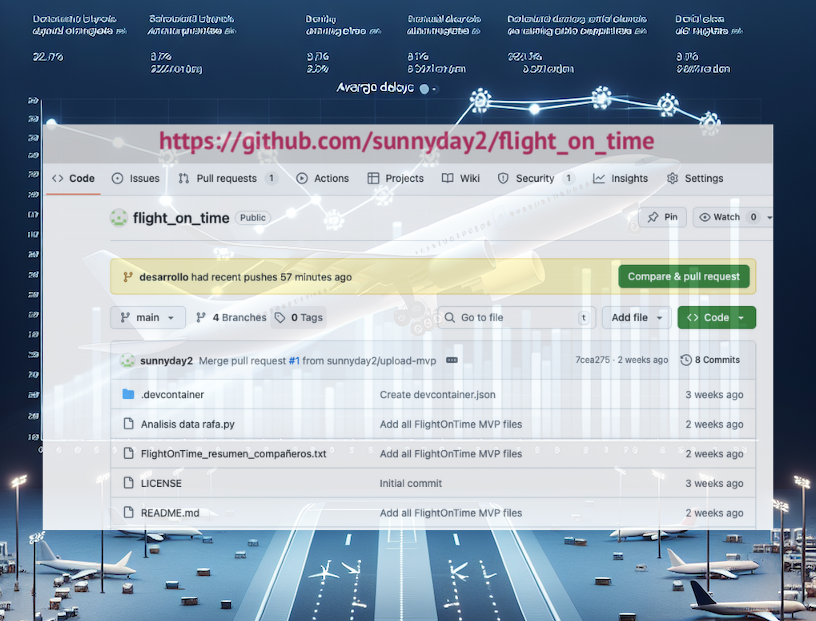